In [1]:
import msprime
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx

set_matplotlib_formats("svg")


# Note: duplicating this from the version used in the pedigrees.md file.
def draw_pedigree(ped_ts):

    G = nx.DiGraph()
    for ind in ped_ts.individuals():
        time = ped_ts.node(ind.nodes[0]).time
        pop = ped_ts.node(ind.nodes[0]).population
        G.add_node(ind.id, time=time, population=pop)
        for p in ind.parents:
            if p != tskit.NULL:
                G.add_edge(ind.id, p)
    pos = nx.multipartite_layout(G, subset_key="time", align="horizontal")
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    node_colours = [colours[node_attr["population"]] for node_attr in G.nodes.values()]
    nx.draw_networkx(G, pos, with_labels=True, node_color=node_colours)
    plt.show()

/tmp/ipykernel_2267/167322575.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


(sec_ancestry)=

# Ancestry simulations

Msprime simulates the ancestry of sampled genomes under a number of
different backwards-in-time population genetic
{ref}`models <sec_ancestry_models>`. The simulated ancestry is
represented as a [succinct tree sequence](https://tskit.dev) using
the [tskit](https://tskit.dev/tskit) library, which provides an
extensive suite of operations for analysing genealogical trees
and DNA sequence data. See the {ref}`tutorials:sec_tskit_getting_started`
tutorial for more information on how to process data using tskit.

Here we run a simple simulation and show a summary of the resulting
tree sequence:

In [2]:
ts = msprime.sim_ancestry(2)
ts

The {func}`.sim_ancestry` function has many parameters to specify
the details of the simulations. The {func}`API documentation <.sim_ancestry>`
contains a precise description of the parameter; the sections
in this page provide some explanation and examples of how to use these
parameters.

:::{note}
It's important to note that {func}`.sim_ancestry` only simulates
the ancestral trees for samples: if we want actual sequence data
then we also need to simulate mutations on these trees.
See the {ref}`sec_mutations` section for more information on how to do
this.
:::

---

(sec_ancestry_quickref)=

## Quick reference

{func}`.sim_ancestry`
: Simulate ancestral tree sequence topology

**Models**

{class}`.StandardCoalescent`
: Coalescent with recombination ("hudson")

{class}`.SmcApproxCoalescent`
: Sequentially Markov Coalescent ("smc")

{class}`.SmcPrimeApproxCoalescent`
: SMC'("smc_prime")

{class}`.DiscreteTimeWrightFisher`
: Generation-by-generation Wright-Fisher

{class}`.FixedPedigree`
: Simulated conditioned on a given pedigree

{class}`.BetaCoalescent`
: Beta coalescent multiple-merger

{class}`.DiracCoalescent`
: Dirac coalescent multiple-merger

{class}`.SweepGenicSelection`
: Selective sweep at a linked locus

---


(sec_ancestry_samples)=

## Specifying samples

The `samples` argument to {func}`.sim_ancestry` defines the number
of sampled individuals whose history will be simulated. There are three different
forms; the `samples` argument can be:

- an **integer**, interpreted as the number of sampled individuals to draw in
  a single population model;
- a **dictionary** mapping population references (either integer IDs or
  names) to the number of sampled individuals for that population;
- a list of {class}`.SampleSet` objects, which provide more flexibility
  in how groups of similar samples are drawn from populations.


In the simplest case, provide a single integer which defines the number
of samples:

In [3]:
ts = msprime.sim_ancestry(2, random_seed=1234)
ts

Here we specify two sample **individuals**, which at the default
ploidy of two, gives us four sample **nodes**.

:::{warning}
It is important to note that the number of samples
refers to the number of *individuals* not the number of *nodes*
(monoploid genomes). See the {ref}`sec_ancestry_ploidy`
section for details.
:::

This integer form for the ``samples`` argument can only be used
when the ``demography`` is a single population model.

### Populations

The next example illustrates one usage of the dictionary form of the `samples`
argument, in which the keys refer to populations in the
{ref}`demographic model<sec_demography>` and
the values are the number of samples to draw.
(See the {ref}`sec_ancestry_demography` section for more details on
the ``demography`` argument to {func}`.sim_ancestry`.)
We first create a {class}`.Demography` object representing
a 10 deme linear stepping stone model. Then, we run the simulation
with 3 diploid samples each drawn from the first and last demes in this
linear habitat.

In [4]:
N = 10
demography = msprime.Demography.stepping_stone_model(
    [100] * N,
    migration_rate=0.1,
    boundaries=True)
ts = msprime.sim_ancestry({0: 3, N - 1: 3}, demography=demography)
ts

The keys in the dictionary can also be the string names of the
population (see the {ref}`sec_demography_populations_identifiers` section),
which is useful when we are simulating from empirically
estimated models. For example, here create a {class}`.Demography` object
based on a species tree, and then draw samples using the species names.

In [5]:
demography = msprime.Demography.from_species_tree(
    "(((human:5.6,chimpanzee:5.6):3.0,gorilla:8.6):9.4,orangutan:18.0)",
    time_units="myr",
    initial_size=10**4,
    generation_time=20)
ts = msprime.sim_ancestry({"gorilla": 2, "human": 4}, demography=demography)
ts

When samples are drawn using this dictionary form it is always
at the population's {ref}`sec_demography_populations_default_sampling_time`.
If you wish to draw samples at a different time, then you must use the
more general form of a list of {class}`.SampleSet` objects.

:::{seealso}
See the {ref}`sec_ancestry_demography` section for more information
on how to specify demographic models in a simulation.
:::

(sec_ancestry_samples_sampling_time)=

### Sampling time

By default the samples that we draw from a {class}`.Population` are
at the population's {attr}`~.Population.default_sampling_time`.
See the {ref}`sec_demography_populations_default_sampling_time`
section for more information about how this is
set for populations in a demographic model.

We can manually control the time at which samples
are drawn using list of {class}`.SampleSet` objects form for the
samples argument.

In this example we create two diploid sample individuals,
one at the present time
and one taken 50 generations ago, representing one modern
and one ancient individual. By default, when we draw the
trees, the nodes that belong to samples are drawn as squares
whereas nodes that are not samples are drawn as circles.

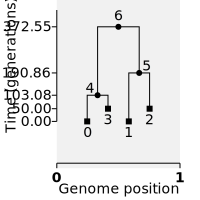

In [6]:
ts = msprime.sim_ancestry(
    samples = [
        msprime.SampleSet(1),
        msprime.SampleSet(1, time=50)
    ],
    population_size=100,
    random_seed=42
)
SVG(ts.draw_svg(y_axis=True))

:::{seealso}
See the {ref}`sec_ancestry_event_order` section for details
of the relative order in which sampling events occur.
:::

(sec_ancestry_samples_sampling_details)=

### Sample details

Sample individuals and nodes are allocated sequentially in the order that
they are specified. For example:

In [7]:
demography = msprime.Demography.island_model([10, 10], migration_rate=1)
ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(1, population=1),
        msprime.SampleSet(2, population=0)],
    demography=demography,
    end_time=0)
print(ts.tables.individuals)
print(ts.tables.nodes)

╔══╤═════╤════════╤═══════╤════════╗
║id│flags│location│parents│metadata║
╠══╪═════╪════════╪═══════╪════════╣
║0 │    0│        │       │        ║
║1 │    0│        │       │        ║
║2 │    0│        │       │        ║
╚══╧═════╧════════╧═══════╧════════╝

╔══╤═════╤══════════╤══════════╤════╤════════╗
║id│flags│population│individual│time│metadata║
╠══╪═════╪══════════╪══════════╪════╪════════╣
║0 │    1│         1│         0│   0│        ║
║1 │    1│         1│         0│   0│        ║
║2 │    1│         0│         1│   0│        ║
║3 │    1│         0│         1│   0│        ║
║4 │    1│         0│         2│   0│        ║
║5 │    1│         0│         2│   0│        ║
╚══╧═════╧══════════╧══════════╧════╧════════╝



(Because we're only interested in the sampled nodes and individuals we
stopped the simulation from actually doing anything by setting
`end_time=0` --- see the {ref}`sec_ancestry_start_time` section
for more information.) Here we define three sample individuals,
and we therefore have three rows in the individual table.
Because these are diploid individuals, the node table contains
six sample nodes. If we look at the `individual` column in the
node table we can see that the first two nodes correspond to individual
`0`, the next two nodes individual `1`, etc. The sample configuration
stated that the first sample should come from population `1` and
the other two from population `0`, and we can see this reflected
in the `population` column of the node table. (Somewhat confusingly,
population values are associated with nodes rather than individuals;
this is mostly for historical reasons.)

The {class}`.SampleSet` class has a number of attributes which default
to `None`. If these are set they will **override** the values
which might be specified elsewhere. For example, we can specify
mixed ploidy samples via the `ploidy` attribute of {class}`.SampleSet`:

In [8]:
ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(1, ploidy=3),
        msprime.SampleSet(2)],
    ploidy=1,
    end_time=0)
print(ts.tables.individuals)
print(ts.tables.nodes)

╔══╤═════╤════════╤═══════╤════════╗
║id│flags│location│parents│metadata║
╠══╪═════╪════════╪═══════╪════════╣
║0 │    0│        │       │        ║
║1 │    0│        │       │        ║
║2 │    0│        │       │        ║
╚══╧═════╧════════╧═══════╧════════╝

╔══╤═════╤══════════╤══════════╤════╤════════╗
║id│flags│population│individual│time│metadata║
╠══╪═════╪══════════╪══════════╪════╪════════╣
║0 │    1│         0│         0│   0│        ║
║1 │    1│         0│         0│   0│        ║
║2 │    1│         0│         0│   0│        ║
║3 │    1│         0│         1│   0│        ║
║4 │    1│         0│         2│   0│        ║
╚══╧═════╧══════════╧══════════╧════╧════════╝



(Again, we stop the simulation immediately because we're only interested
in the initial samples.) Here we have three sampled individuals again
but in this they are mixed ploidy: the first individual is triploid
and the other two are haploid.

:::{warning}
It is vital to note that setting the `ploidy` value
of {class}`.SampleSet` objects only affects sampling and does
not affect the actual simulation. In this case, the simulation
will be run on the haploid time scale. See the
{ref}`sec_ancestry_ploidy` section for more details.
:::

If you wish to set up the node and individual IDs in some other way,
it is possible to do so by using the ``initial_state`` parameter.
See the  {ref}`sec_ancestry_initial_state` for more information
on how to use this (advanced) feature.

(sec_ancestry_demography)=

## Demography

A {ref}`demographic model<sec_demography>` is a description of a
set of populations, the migration rates between then and the
events that modify the populations over time. Ancestry simulations
can take one of these models as input via the ``demography``
parameter to {func}`.sim_ancestry`.

:::{seealso}
Please see the {ref}`sec_demography` section for details on how
to create and debug demographic models, and the
{ref}`sec_ancestry_samples` section for help on how to
define the locations and times of sampled individuals.
:::

We don't need to explicitly specify a {class}`.Demography`
for every ancestry simulation, however. By default, we assume a
single fixed-size population. For the default
{ref}`standard coalescent<sec_ancestry_models_hudson>` ancestry
model we assume a population size of 1, so that time is measured
in "coalescent units". This is useful for theoretical work where
we usually work in scaled coalescent time.

:::{important}
By default msprime uses the **diploid** coalescent time scale;
see the {ref}`sec_ancestry_ploidy` section for more details.
:::

Outside of theoretical analysis, working with scaled
coalescent time can be confusing and it's usually better to
explicitly set the population size so that the output
times are directly interpretable in generations.
The ``population_size`` parameter to {func}`.sim_ancestry`
allows us to set the size of the single constant
sized population in the default demography.

For example, here we run the same simulation twice, one with
the default population size and one with a population size
of 100:

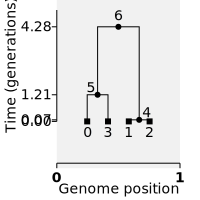

In [9]:
ts = msprime.sim_ancestry(2, random_seed=1234)
SVG(ts.draw_svg(y_axis=True))

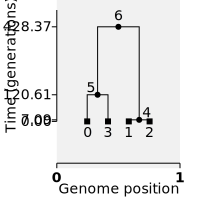

In [10]:
ts = msprime.sim_ancestry(2, population_size=100, random_seed=1234)
SVG(ts.draw_svg(y_axis=True))

We can see that the results are identical, except the node times have
been scaled by the population size.

The {ref}`sec_ancestry_models_dtwf` model is different. Because it
explicitly works with a population of N individuals we get an
error if we don't specify a population size:

In [11]:
msprime.sim_ancestry(2, model="dtwf", random_seed=1234)

ValueError: When using the DTWF model, the population size must be set explicitly, either using the population_size or demography arguments.

:::{note}
Because the DTWF models populations of individuals rather than
using continuous
time approximations, simulations with different population sizes
will yield entirely different results; we are **not** simply
rescaling time by using different population sizes. Furthermore,
simulations with large population sizes will take relatively
more CPU time and memory.
:::

---

(sec_ancestry_ploidy)=

## Ploidy

The ``ploidy`` argument to {func}`.sim_ancestry` has two effects:

1. It sets the default ploidy, that is, the number of nodes per sample individual.
2. For continuous time coalescent models, it sets the time scale.

Both of these are somewhat confusing, so let's look at them one at a time.

(sec_ancestry_ploidy_default_num_nodes)=

### Default number of nodes per sample individual

As discussed in the {ref}`sec_ancestry_samples_sampling_details` section,
the number of nodes (i.e., monoploid genomes) that we allocate per
sample individual is determined by the ploidy. Here, we specify
2 sample individuals with a ploidy of 3:

In [12]:
ts = msprime.sim_ancestry(samples=2, ploidy=3, end_time=0)
print(ts.tables.individuals)
print(ts.tables.nodes)

╔══╤═════╤════════╤═══════╤════════╗
║id│flags│location│parents│metadata║
╠══╪═════╪════════╪═══════╪════════╣
║0 │    0│        │       │        ║
║1 │    0│        │       │        ║
╚══╧═════╧════════╧═══════╧════════╝

╔══╤═════╤══════════╤══════════╤════╤════════╗
║id│flags│population│individual│time│metadata║
╠══╪═════╪══════════╪══════════╪════╪════════╣
║0 │    1│         0│         0│   0│        ║
║1 │    1│         0│         0│   0│        ║
║2 │    1│         0│         0│   0│        ║
║3 │    1│         0│         1│   0│        ║
║4 │    1│         0│         1│   0│        ║
║5 │    1│         0│         1│   0│        ║
╚══╧═════╧══════════╧══════════╧════╧════════╝



:::{note}
Because we're only interested in the initial conditions here we
set the ``end_time`` to zero: see the {ref}`sec_ancestry_start_time`
section for more details.
:::

Our individual table has two rows (the number of ``samples``)
and node table has 6 rows: three for each of the sampled
individuals.

Note that this is the **default**, and can be overridden by the
{attr}`.SampleSet.ploidy` value, as described in the
{ref}`sec_ancestry_samples_sampling_details` section.

(sec_ancestry_ploidy_coalescent_time_scales)=

### Coalescent time scales

The ploidy argument also
affects the time scale on which coalescence occurs,
since it affects the total number of genomes in the population
(see also {ref}`population size<sec_ancestry_demography>`).
For example, consider the following two simulations, which
are identical except for different ``ploidy`` values
(note we use the {class}`.SampleSet` object to make
sure we allocate the same number of **nodes**, as discussed
in the {ref}`sec_ancestry_ploidy_default_num_nodes` section):

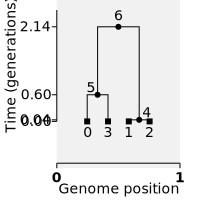

In [13]:
ts = msprime.sim_ancestry(
    samples=[msprime.SampleSet(4, ploidy=1)],
    population_size=1,
    ploidy=1,
    random_seed=1234
)
SVG(ts.draw_svg(y_axis=True))

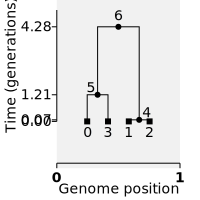

In [14]:
ts = msprime.sim_ancestry(
    samples=[msprime.SampleSet(4, ploidy=1)],
    population_size=1,
    ploidy=2,
    random_seed=1234
)
SVG(ts.draw_svg(y_axis=True))

The resulting tree sequences are identical, except that node time differ by a
factor of 2, because in the underlying coalescent algorithm the total number of
genomes in the population acts as a time scaling.

:::{todo}
Add a discussion here about the Lambda coalescents an how
things are more complicated for them.
:::

:::{important}
The {ref}`sec_ancestry_models_dtwf` model is an explicitly diploid model
and it is therefore
an error to run it with any ``ploidy`` value other than 2.
:::

(sec_ancestry_genome_properties)=

## Genome properties

(sec_ancestry_sequence_length)=

### Sequence length

There are a number of ways to specify the length of the
chromosome that we want to simulate. In the absence of recombination
and gene conversion, we assume a genome of length 1:

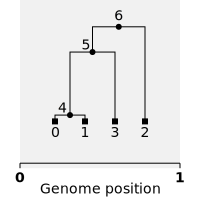

In [15]:
ts = msprime.sim_ancestry(2, random_seed=1)
SVG(ts.draw_svg())

The ``sequence_length`` parameter determines the length of the
simulated sequence:

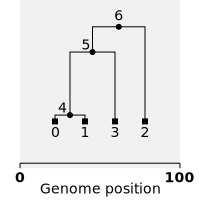

In [16]:
ts = msprime.sim_ancestry(2, sequence_length=100, random_seed=1)
SVG(ts.draw_svg())

By default there is no recombination or gene conversion, and so we
therefore still have only one tree defining the ancestry of the
samples. The sequence length makes little difference if we are
considering only the ancestry of a non-recombining sequence, however,
this will be important if we are interested in adding
{ref}`mutations<sec_mutations>` later.

(sec_ancestry_recombination)=

### Recombination

As we trace the ancestry of a sample of genomes backwards in time,
recombination has the effect of creating segments of genome
that have different (but highly correlated) genealogical trees.
The {func}`.sim_ancestry` function has a ``recombination_rate``
argument that allows us to flexibly specify both uniform and
non-uniform rates of recombination along the genome.

The simplest way to run simulations with recombination is to
use the ``recombination_rate`` and ``sequence_length`` parameters:

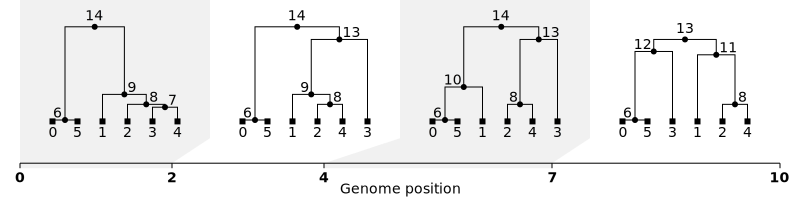

In [17]:
ts = msprime.sim_ancestry(
    3, recombination_rate=0.1, sequence_length=10, random_seed=2)
SVG(ts.draw_svg())

Here, we have four distinct trees along the genome,
created by recombination events.

In [18]:
assert 1 < ts.num_trees < 5

We can also provide a {class}`.RateMap` argument to ``recombination_rate``:

In [19]:
rate_map = msprime.RateMap.uniform(sequence_length=10, rate=0.1)
other_ts = msprime.sim_ancestry(3, recombination_rate=rate_map, random_seed=2)
assert ts.equals(other_ts, ignore_provenance=True)

There are two things to note here:

1. We didn't need to specify a ``sequence_length`` argument to
{func}`.sim_ancestry`, as this information is encapsulated by the ``rate_map``
instance. (We can provide a value for ``sequence_length`` if we wish, but
it must be equal to the {attr}`~.RateMap.sequence_length` property of the
{class}`.RateMap`).
2. The result of the simulation for a {ref}`sec_rate_maps_creating_uniform`
rate map with the same rate and ``sequence_length`` is identical to
the first simulation above.

We can simulate non-uniform recombination by defining our {class}`.RateMap`
appropriately. For example, here we define a map in which the
rate over the first half of the sequence is one tenth of the second half:

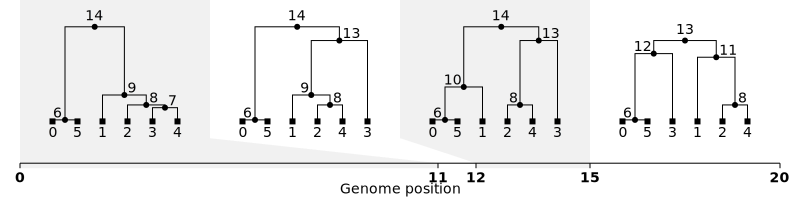

In [20]:
rate_map = msprime.RateMap(position=[0, 10, 20], rate=[0.01, 0.1])
ts = msprime.sim_ancestry(3, recombination_rate=rate_map, random_seed=2)
SVG(ts.draw_svg())

Because the recombination rate in from position 10 to 20 is so much
higher than the rate from 0 to 10, we can see that all the recombinations
have fallen in the high recombination region.

:::{seealso}
- See the {ref}`sec_rate_maps_creating` section for more examples of
creating {class}`.RateMap` instances.

- See the {meth}`.RateMap.read_hapmap` method for reading in
genetic maps from text files.
:::

(sec_ancestry_gene_conversion)=

### Gene conversion

Gene conversion events are defined by two parameters: the rate at which gene
conversion events are initiated and the distribution of tract lengths.
In the default case of discrete genome coordinates, tract lengths are drawn
from a geometric distribution with mean ``gene_conversion_tract_length`` (which
must be at least 1). Note that if we specify a tract length of 1, then all
gene conversion tracts will have length exactly 1.
In the following example one gene conversion event of length 1 has occurred:

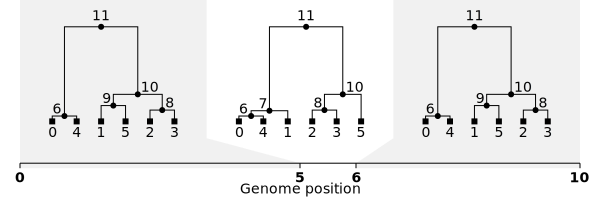

In [21]:
ts = msprime.sim_ancestry(
    3, gene_conversion_rate=0.02, gene_conversion_tract_length=1,
    sequence_length=10, random_seed=3)
SVG(ts.draw_svg())

:::{note}
We can see the specific effect of gene conversion here in this simple
example, because the trees at either side of the event are identical.
However, this will not be true in general.
:::

In [22]:
assert ts.num_trees == 3
assert ts.at(0).parent_dict == ts.at(2).parent_dict

Continuous genomes can also be used. In this case the parameters define
the rate at which gene conversion events are initiated per unit of sequence
length and the mean of the exponentially distributed gene conversion tract
lengths. The following example shows the same simulation as above but for a
continuous genome:

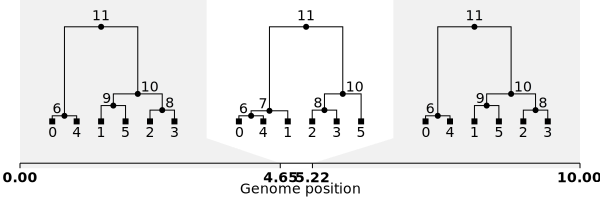

In [23]:
ts = msprime.sim_ancestry(
    3, gene_conversion_rate=0.02, gene_conversion_tract_length=1,
    sequence_length=10, random_seed=3, discrete_genome=False)
SVG(ts.draw_svg())

In [24]:
assert ts.num_trees == 3

Recombination and gene conversion at constant rates can be simulated alongside.
In the following example recombinations at site 60 and 97 have occurred in addition
to a gene conversion event covering the tract from site 76 to site 80.

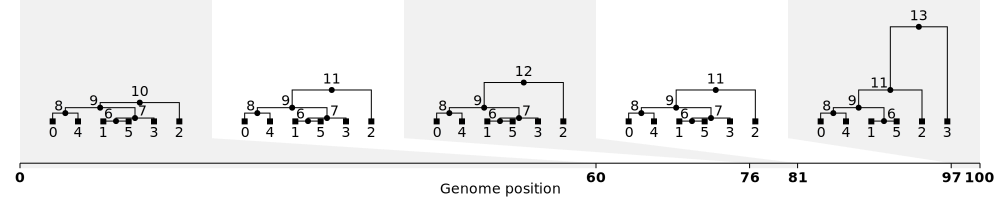

In [25]:
ts = msprime.sim_ancestry(
    3, sequence_length = 100, recombination_rate=0.003,
    gene_conversion_rate=0.002, gene_conversion_tract_length=5,
    random_seed=6)
SVG(ts.draw_svg())

In [26]:
assert 1 < ts.num_trees < 6

Variable recombination rates and constant gene conversion rates
can also be combined.

:::{note}
Variable rates of gene conversion breakpoint initiation are not currently
supported, but are planned for a future release. If you are interested
in this feature please let us know!
:::

(sec_ancestry_discrete_genome)=

### Discrete or continuous?

By default, we assume that the genome we are simulating is *discrete*
so that genome coordinates are at integer positions:

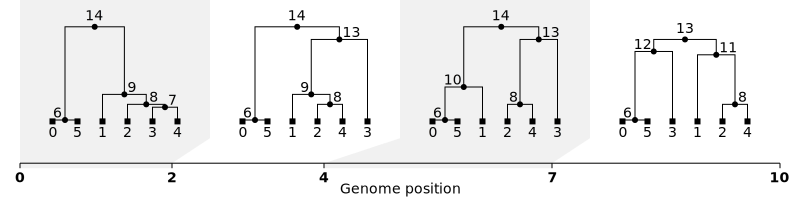

In [27]:
ts = msprime.sim_ancestry(
    3, recombination_rate=0.1, sequence_length=10, random_seed=2)
SVG(ts.draw_svg())

In [28]:
assert 1 < ts.num_trees < 5

Alternatively, we can simulate a continous genome by setting
`discrete_genome=False`:

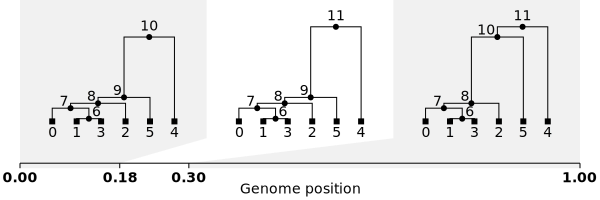

In [29]:
ts = msprime.sim_ancestry(
    3, recombination_rate=0.25, sequence_length=1, discrete_genome=False,
    random_seed=33)
SVG(ts.draw_svg())

In [30]:
assert 1 < ts.num_trees < 5

Here we see that the breakpoints along the genome occur at floating point
positions. Simulating a continuous genome sequence can be useful for
theoretical work, but we recommend using discrete coordinates for most
purposes.


(sec_ancestry_multiple_chromosomes)=

### Multiple chromosomes

#### Do I need to do this?

The main purpose of simulating multiple chromosomes together (instead of
running independent simulations for each chromosome) is to capture
correlations between trees on distinct chromosomes. In many scenarios,
**simulating multiple chromosomes may not be necessary**, and independent
simulations may be preferable as they will be much more efficient.

That being said, this section describes how to simulate data over
multiple chromosomes, or more generally, over multiple regions
with free recombination between them. 

#### Using a fixed pedigree

The most natural way to simulate multiple regions with free recombination for
a set of sampled individuals is by simulating through a known pedigree. The
{ref}`fixed pedigree <sec_ancestry_models_fixed_pedigree>` simulation model
constrains simulated genomic regions by an input pedigree, which specifies
parent-offspring relationships. Since autosomal genetic material in an
offspring has equal chance of being inherited from either their mother or their
father, independent simulations through the same pedigree ensures that those
regions are inherited from different parents or from the same parent each with
probability 1/2. This ensures free recombination between independent
simulations.

We often do not have a full pedigree, but instead have a pedigree that
extends some number of generations into the past. Because a recombination
fraction of 1/2 between regions causes correlations between chromosomes to
decay rapidly, even shallow pedigrees containing just a handful of generations
should broadly capture expected levels of correlations. At the termination of
the pedigree, the simulation can be completed using the DTWF, Hudson, or other
model. See {ref}`example 1 <sec_multi_chrom_example_1>` below for a small
example of this procedure, and more details on completing pedigree simulations
can be found in the {ref}`Fixed pedigree <sec_ancestry_models_fixed_pedigree>`
section.

Why might simulating multiple chromosomes using a pedigree be preferable to
other simulation options? First, there is no need to concatenate recombination
maps for multiple chromosomes, as each region is simulated independently. This
also results in simpler, reusable code which can be parallelized. Finally, this
approach improves efficiency over a single larger simulation of multiple
concatenated chromosomes, as computational costs scale as the square of the
sequence length.

#### Simulations without a fixed pedigree

Without a pedigree, we can use other simulation models in msprime such as
{ref}`DTWF <sec_ancestry_models_dtwf>` and the 
{ref}`multiple merger coalescent <sec_ancestry_models_multiple_mergers>`.
These models do not directly support simulating multiple chromosomes
simultaneously, but we can emulate it using a single linear genome split into
chromosome segments. In this case, multiple chromosomes are modelled by specifying
a recombination map with single base-pair segments with recombination
probability 1/2 separating adjacent chromosomes.
The probability that two chromosomes are co-inherited across {math}`t` generations
is {math}`2^{-t}`. In the Poisson model of recombination used by msprime, the
probability of co-inheritance across {math}`t` generations of two adjacent base
pairs separated by a recombination rate {math}`r` per base pair is {math}`e^{-rt}`.
To make these agree, we set the recombination rate in the base pair segments
separating chromosomes to {math}`\log(2)`.

[Nelson et al. 2020](https://doi.org/10.1371/journal.pgen.1008619) describes
a few cases where simulating multiple chromosomes using the DTWF is important
for accurately modeling shared patterns of variation between samples.
In large simulated cohorts, where many samples can be close
relatives, we need the DTWF model and multiple chromosomes to obtain the
correct distribution of the number and total length of shared IBD segments. We
similarly require multiple chromosomes and the DTWF model to get the correct
ancestry patterns for very recently admixed populations.

Additionally,
{ref}`Multiple merger coalescents <sec_ancestry_models_multiple_mergers>`
result in positively correlated ancestries between unlinked chromosomes
(see [Birkner et al. 2013](https://www.genetics.org/content/193/1/255)).
This correlation does not break down in time and multiple chromosomes should
not be simulated independently under the multiple merger models. Unlinked
chromosomes should scatter into distinct ancestors instantaneously under
multiple merger coalescents, not with probability 1/2 per generation
as in discrete population models. In msprime, this waiting time of length zero
is approximated by an exponential distribution with rate {math}`r`, i.e. the
recombination rate at the base pair separating the chromosomes, which
should be set to a high enough value to obtain an acceptable approximation.
We recommend considering in particular the relative error in comparison to
the magnitudes other waiting times which are likely to arise in the simulation.

:::{important}
Simulations of multiple chromosomes under either DTWF or the multiple merger
models should use a {ref}`discrete genome <sec_ancestry_discrete_genome>`.
While it is possible to set up such a simulation using a continuous genome,
we *strongly* recommend against it, as chromosome divisions cannot be defined
as discrete break points and the simulation will be very inefficient.
:::

(sec_multi_chrom_example_1)=

#### Example 1: simulating with a pedigree

In this example, we simulate genomic data for a pair of first cousins in
a small pedigree extending 3 (?) generations into the past. See {ref}`here
<sec_ancestry_models_fixed_pedigree>` for details on specifying, importing, and
simulating using pedigrees.

Let's first specify our pedigree:

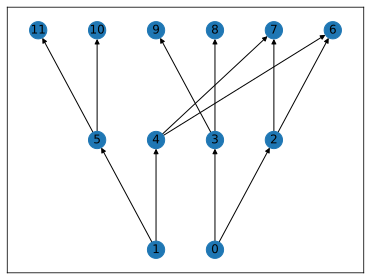

In [31]:
import io
import tskit
ped_txt = """\
# id parent0 parent1 time is_sample
0   2   3   0.0 1
1   4   5   0.0 1
2   6   7   1.0 0
3   8   9   1.0 0
4   6   7   1.0 0
5   10  11  1.0 0
6   .   .   2.0 0
7   .   .   2.0 0
8   .   .   2.0 0
9   .   .   2.0 0
10  .   .   2.0 0
11  .   .   2.0 0
"""
pedigree = msprime.parse_pedigree(io.StringIO(ped_txt), sequence_length=100)

draw_pedigree(pedigree.tree_sequence())

Then suppose we would like to simulate three chromosomes of differing lengths
and recombination rates. In practice, we might have recombination
maps for each chromosome, but the general strategy remains the same.

In [32]:
Ls = [1000000, 2000000, 3000000]
rs = [1e-8, 2e-8, 3e-8]

ts_chroms = []
pedigree = msprime.parse_pedigree(io.StringIO(ped_txt), sequence_length=1)

for i, (L, r) in enumerate(zip(Ls, rs)):
    pedigree.sequence_length = L
    ped_ts = msprime.sim_ancestry(
        initial_state=pedigree, model="fixed_pedigree",
        recombination_rate=r, random_seed=i+1)
    ts_chroms.append(
        msprime.sim_ancestry(
            initial_state=ped_ts, population_size=1000,
            recombination_rate=r, model="dtwf", random_seed=i+100))

for i, ts in enumerate(ts_chroms):
    print(f"chromosome {i} has length {ts.sequence_length} and {ts.num_trees} trees")

chromosome 0 has length 1000000.0 and 48 trees
chromosome 1 has length 2000000.0 and 155 trees
chromosome 2 has length 3000000.0 and 377 trees


This results in three chromosomes of the desired lengths.

(sec_multi_chrom_example_2)=

#### Example 2: simulating without a pedigree

We first set up the chromosome coordinates, recombination rates, and the
corresponding recombination map. The following defines a recombination map for
three chromosomes each 1 cM in length:

In [33]:
import math

r_chrom = 1e-8
r_break = math.log(2)
chrom_positions = [0, 1e6, 2e6, 3e6]
map_positions = [
    chrom_positions[0],
    chrom_positions[1],
    chrom_positions[1] + 1,
    chrom_positions[2],
    chrom_positions[2] + 1,
    chrom_positions[3]
]
rates = [r_chrom, r_break, r_chrom, r_break, r_chrom]
rate_map = msprime.RateMap(position=map_positions, rate=rates)

We cannot use the default {class}`.StandardCoalescent` model to run simulations
of multiple chromosomes; doing so would be equivalent to running independent
replicate simulations and **much** less efficient. To get the correct
correlation between chromosomes, we must use a model like
{ref}`discrete-time Wright-Fisher <sec_ancestry_models_dtwf>`.
However, because correlations
between chromosomes break down very rapidly, we only need to simulate using
`dtwf` for roughly 10-20 generations, after which we can switch to the `hudson`
model to finish the simulation more efficiently (see the
{ref}`sec_ancestry_models_specifying` section for more information on switching
between ancestry models).

In this example, we simulate 10 sampled diploid individuals using the
recombination map defined above for three chromosomes and switching from the
`dtwf` to `hudson` model 20 generations ago:

In [34]:
ts = msprime.sim_ancestry(
    10,
    population_size=1000,
    recombination_rate=rate_map,
    model=[
        msprime.DiscreteTimeWrightFisher(duration=20),
        msprime.StandardCoalescent(),
    ],
    random_seed=1234,
)
ts

To place each chromosome in its own separate tree sequence, we can trim the full tree
sequence for each chromosome by defining the end points of each chromosome and
using the {meth}`~tskit.TreeSequence.keep_intervals` method. It is important to
specify `simplify=False` so that node indices remain consistent across
chromosomes. The {meth}`~tskit.TreeSequence.trim` method is then used to trim
the tree sequences to the focal chromosome, so that position indices begin at
0 within each chromosome tree sequence.

In [35]:
ts_chroms = []
for j in range(len(chrom_positions) - 1):
    start, end = chrom_positions[j: j + 2]
    chrom_ts = ts.keep_intervals([[start, end]], simplify=False).trim()
    ts_chroms.append(chrom_ts)
    print(chrom_ts.sequence_length)

# the third chromosome
chrom_ts

1000000.0
1000000.0
1000000.0


This gives us a list of tree sequences, one for each chromosome, in the order
that they were stitched together in the initial recombination map.

:::{note}
Many recombination maps inferred from data will contain regions at the start
and end of the chromosome where recombination rates could not be inferred.
These regions typically are assigned rate values of NaN. If we were to
concatenate multiple recombination maps that have flanking NaN regions, the
resulting maps would have regions with NaN rates in the interior of the map,
which will produce an error when using such a map in simulations.

These regions typically represent unassay-able segments of the chromosome, and
simulated genetic material in these regions should be discarded in downstream
analyses. Thus, the suggested approach is to modify the recombination maps to
set rates to zero in these flanking regions, concatenate the maps as shown in
this example, and then remove those regions of the resulting tree sequences by
calling `ts.delete_intervals(nan_intervals)`, where `nan_intervals` is a list
containing `[start, end]` values for each NaN flanking region.
:::

## Recording more information

By default `msprime` stores the minimum amount of information required
to represent the simulated genealogical history of the samples. Sometimes
we are interested in more detailed information; this section gives details
of options that allow us to do this.

(sec_ancestry_full_arg)=

### Ancestral recombination graph

In `msprime` we usually want to simulate the coalescent with recombination
and represent the output as efficiently as possible. As a result, we don't
store individual recombination events, but rather their effects on the output
tree sequence. We also do not explicitly store common ancestor events that
do not result in marginal coalescences. For some purposes, however, we want
to get information on the full history of the simulation, not just the minimal
representation of its outcome. The `record_full_arg` option to
{func}`.sim_ancestry` provides this functionality, as illustrated in the
following example:

╔══╤══════╤══════════╤══════════╤══════════╤════════╗
║id│flags │population│individual│time      │metadata║
╠══╪══════╪══════════╪══════════╪══════════╪════════╣
║0 │     1│         0│         0│0.00000000│        ║
║1 │     1│         0│         0│0.00000000│        ║
║2 │     1│         0│         1│0.00000000│        ║
║3 │     1│         0│         1│0.00000000│        ║
║4 │     1│         0│         2│0.00000000│        ║
║5 │     1│         0│         2│0.00000000│        ║
║6 │     0│         0│        -1│0.21230674│        ║
║7 │     0│         0│        -1│0.51485157│        ║
║8 │     0│         0│        -1│0.71161449│        ║
║9 │131072│         0│        -1│0.91107705│        ║
║10│131072│         0│        -1│0.91107705│        ║
║11│262144│         0│        -1│1.21743776│        ║
║12│     0│         0│        -1│1.23130397│        ║
║13│     0│         0│        -1│4.80416300│        ║
╚══╧══════╧══════════╧══════════╧══════════╧════════╝



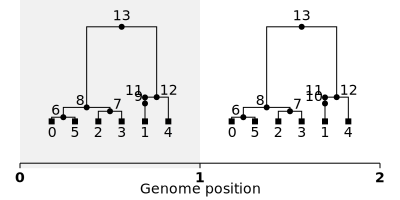

In [36]:
ts = msprime.sim_ancestry(
    3, recombination_rate=0.1, sequence_length=2,
    record_full_arg=True, random_seed=42)
print(ts.tables.nodes)
SVG(ts.draw_svg())

After running the simulation we first print out the
[node table](<https://tskit.readthedocs.io/en/stable/data-model.html#node-table>), which
contains information on all the nodes in the tree sequence. Note that `flags`
column contains several different values: all of the sample nodes (at time 0)
have a flag value of `1` ({data}`tskit.NODE_IS_SAMPLE`). Most other
nodes have a flag value of `0`, which is the standard for internal nodes
in a coalescent simulations.

Nodes 9 and 10 have flags equal to 131072 ({data}`.NODE_IS_RE_EVENT`), which
tells us that they correspond to a recombination event in the ARG. A
recombination event results in two extra nodes being recorded, one identifying
the individual providing the genetic material to the left of the breakpoint and
the other identifying the individuals providing the genetic material to the
right. The effect of this extra node can be seen in the trees: node 9 is
present as a 'unary' node in the left hand tree and node 10 in the right.

In this particular case, the first thing that happens to these two lineages
as we go up the tree sequence is that they coalesce straight back together again
at node 11, forming a (normally undetectable) "diamond event" in the ARG, and
explaining why the topology of both these trees appears the same. In a full ARG,
this is one of many ways that a coalescent event can occur without resulting in a
marginal coalescence, and which instead results in an additional unary node in the
trees. Such nodes are given a flags value of 262144 ({data}`.NODE_IS_CA_EVENT`).

If we wish to reduce these trees down to the minimal representation, we can
use {meth}`tskit.TreeSequence.simplify`. The resulting tree sequence will have
all of these unary nodes removed and will be equivalent to (but not identical, due to
stochastic effects) calling {func}`.sim_ancestry` without the `record_full_arg`
argument.

Migrations nodes are also recording in the ARG using the
{data}`.NODE_IS_MIG_EVENT` flag. See the {ref}`sec_api_node_flags`
section for more details.

(sec_ancestry_record_migrations)=

### Migration events

In [37]:
    msprime.core.set_seed_rng_seed(42)

When running simulations with {ref}`demography <sec_demography>`, by
default, migration events are not recorded in the resulting tree sequence.
While the population associated with each node is determined by the simulated migration
events, knowledge of the
precise sequence of migrations is useful in a number of situations: for example see
the `tskit`
[tutorial on introgression.](<https://tskit-dev.github.io/tutorials/introgression.html>)

The `record_migrations` parameter allows us to record these events in the
simulated tree sequence outputted by {func}`.sim_ancestry`. Briefly, a migration record
encodes the node associated with the migration, the time of the event, the source and
destination populations (backwards in time), and the left and right coordinates of the
migrating segement. For more details on migration records, see the
{ref}`migration table definition.<tskit:sec_migration_table_definition>`

Here, we provide a simple example of the effect of setting `record_migrations=True`
using the {meth}`stepping stone model<msprime.Demography.stepping_stone_model>`
where migration is permitted between adjacent populations. Additionally, we
set `record_full_arg=True` (see {ref}`previous section <sec_ancestry_full_arg>`)
to record nodes corresponding to migration events. This is not necessary, but will be
helpful to visualise the result.

In [38]:
N = 10
demography = msprime.Demography.stepping_stone_model(
    [20] * N, migration_rate=0.1, boundaries=True
)
ts = msprime.sim_ancestry(
    {0: 1, N - 1: 1},
    demography=demography,
    record_migrations=True,
    record_full_arg=True,
    random_seed=6,
)

In the following visualisation, we trace the migration history of two samples backwards
in time to their most recent common ancestor. Each one of the ten populations in the
model is assigned a
colour and a position on the x axis. The time of migration events is recorded on the y
axis.

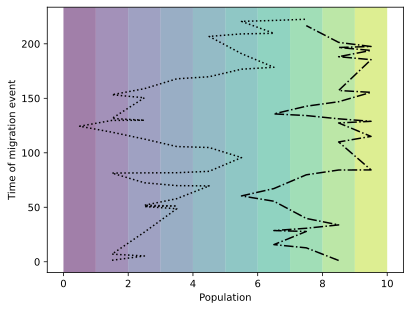

In [39]:
import tskit
import numpy as np
import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')
tree = ts.first()
mig_color_dict = {}
for u, linestyle in zip(ts.samples()[::2], ["dotted", "dashdot"]):
    mig = ts.tables.migrations
    loc = []
    time = []
    while u != tskit.NULL:
        migs = np.where(mig.node == u)[0]
        for cur_mig in migs:
            cur_mig = mig[cur_mig]
            loc.append(cur_mig.dest + 0.5)
            time.append(cur_mig.time)
        u = tree.parent(u)
    plt.plot(loc, time, linestyle=linestyle, color="black")
for i in range(N):
    rgba = cmap(i / N)
    mig_color_dict[i] = np.array(rgba)*255
    plt.axvspan(i, i+1, facecolor=rgba, alpha=0.5)
plt.ylabel("Time of migration event")
plt.xlabel("Population")
plt.show()

Note also how many migration events occurred before the two
samples coalesced, even in this small example.

The next visualisation shows where each of these migrations fall on the edges
of the simulated tree. We show the nodes associated with each migration
event, colouring nodes and edges by the population with which they are associated
(using the same colour scheme as the previous visualisation).

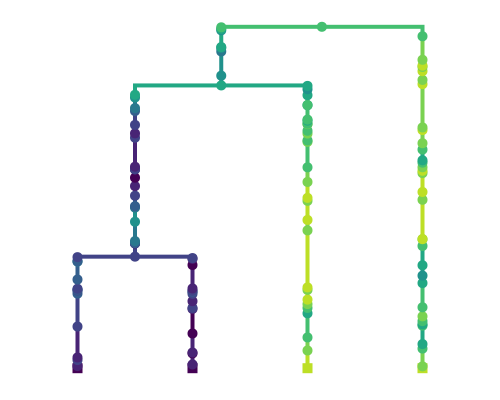

In [40]:
mig_color_dict = {}
cmap = matplotlib.cm.get_cmap("viridis")
for i in range(N):
    rgba = cmap(i / N)
    mig_color_dict[i] = np.array(rgba) * 255

edge_colors = {}
string = ".tree .edge {stroke-width:4px}"
pop = ts.tables.nodes.population
for node in ts.nodes():
    node = node.id
    edge_colors[node] = mig_color_dict[pop[node]]
    string += (
        ".node.n"
        + str(node)
        + "> .sym {fill: rgb"
        + str(tuple(mig_color_dict[pop[node]][0:3]))
        + "}"
    )
    string += (
        ".node.n"
        + str(node)
        + " > .edge {stroke: rgb"
        + str(tuple(mig_color_dict[pop[node]][0:3]))
        + "}"
    )
for mig in ts.migrations():
    edge_colors[mig.node] = mig_color_dict[mig.source]
    string += (
        ".node.n"
        + str(mig.node)
        + "> .sym {fill: rgb"
        + str(tuple(mig_color_dict[pop[mig.node]][0:3]))
        + "}"
    )
    string += (
        ".node.n"
        + str(mig.node)
        + " > .edge {stroke: rgb"
        + str(tuple(mig_color_dict[mig.dest][0:3]))
        + "}"
    )
node_labels = {node.id: "" for node in ts.nodes()}
SVG(
    ts.first().draw_svg(
        size=(500, 400), style=string, node_labels=node_labels, symbol_size=10
    )
)

(sec_ancestry_census_events)=

### Census events

Census events allow you to add a node to each branch of the tree sequence at a given time
during the simulation. This can be useful when you wish to study haplotypes that are
ancestral to your simulated sample, or when you wish to know which lineages were present in
which populations at specified times.

For instance, the following example creates a two population island
model {class}`.Demography`, with the populations exchanging migrants
at rate 0.05. At generation 5000, we add a census event using the
{meth}`.Demography.add_census` method
to determine where each of the lineages is at that time:

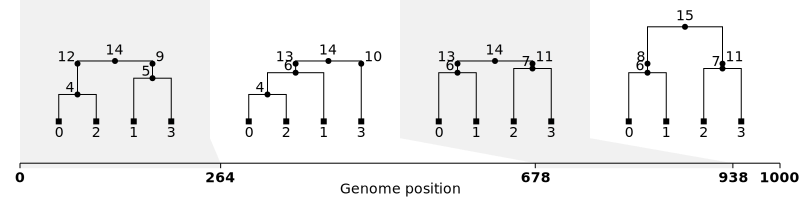

In [41]:
demography = msprime.Demography.island_model([1000, 1000], migration_rate=0.05)
demography.add_census(time=5000)
ts = msprime.sim_ancestry(
    {0: 1, 1: 1},
    demography=demography,
    recombination_rate=1e-7,
    sequence_length=1000,
    random_seed=141
)
SVG(ts.draw_svg())

The resulting tree sequence has nodes on each tree at the specified census time.
These are the nodes with IDs 8, 9, 10, 11, 12 and 13.

This tells us that the genetic material ancestral to the present day sample was
held within 5 haplotypes at time 5000. The node table shows us that four of
these haplotypes (nodes 8, 9, 10 and 11) were in population 0 at this time, and
two of these haplotypes (nodes 12 and 13) were in population 1 at this time.

In [42]:
print(ts.tables.nodes)

╔══╤═══════╤══════════╤══════════╤═════════════╤════════╗
║id│flags  │population│individual│time         │metadata║
╠══╪═══════╪══════════╪══════════╪═════════════╪════════╣
║0 │      1│         0│         0│   0.00000000│        ║
║1 │      1│         0│         0│   0.00000000│        ║
║2 │      1│         1│         1│   0.00000000│        ║
║3 │      1│         1│         1│   0.00000000│        ║
║4 │      0│         1│        -1│2331.91109774│        ║
║5 │      0│         1│        -1│3741.02811877│        ║
║6 │      0│         0│        -1│4216.80416680│        ║
║7 │      0│         1│        -1│4580.66488183│        ║
║8 │1048576│         0│        -1│5000.00000000│        ║
║9 │1048576│         0│        -1│5000.00000000│        ║
║10│1048576│         0│        -1│5000.00000000│        ║
║11│1048576│         0│        -1│5000.00000000│        ║
║12│1048576│         1│        -1│5000.00000000│        ║
║13│1048576│         1│        -1│5000.00000000│        ║
║14│      0│  

If we wish to study these ancestral haplotypes further, we can simplify the tree sequence
with respect to the census nodes and perform subsequent analyses on this simplified tree
sequence.
In this example, `ts_anc` is a tree sequence obtained from the original tree sequence
`ts` by labelling the census nodes as samples and removing all nodes and edges that are
not ancestral to these census nodes.

In [43]:
nodes = [i.id for i in ts.nodes() if i.flags==msprime.NODE_IS_CEN_EVENT]
ts_anc = ts.simplify(samples=nodes)

(sec_ancestry_census_events_dtwf)=

#### Using the DTWF model

Census events assume that they are being used as part of a continuous time
simulation process, in which multiple events are guaranteed not to happen
at the same time. However, the {class}`.DiscreteTimeWrightFisher` model does
not meet these assumptions, and allows multiple events (such as coalescences,
migrations etc) to all occur at the same time. This includes census events,
which can lead to errors when used in conjunction with the DTWF model.

Consider the following example:

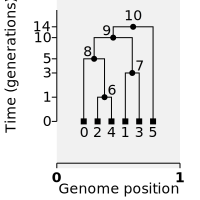

In [44]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=10)
ts = msprime.sim_ancestry({"A": 3}, demography=demography, model="dtwf", random_seed=33)
SVG(ts.draw_svg(y_axis=True, time_scale="log_time"))

We can see that a coalescence happens at time 3, giving node 7. Now, let's
try to perform a census at time 3:

In [45]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=10)
demography.add_census(time=3)
ts = msprime.sim_ancestry({"A": 3}, demography=demography, model="dtwf", random_seed=33)

LibraryError: The simulation model supplied resulted in a parent node having a time value <= to its child. This can occur as a result of multiple bottlenecks happening at the same time, multiple census events at the same time or numerical imprecision with very smallpopulation sizes.

We got an error from msprime about a parent node having a time value <= to its child,
which occurred because we tried to add set of census nodes at time 3, but node 7 was
already at time 3, giving a zero branch length (which is disallowed by tskit).

The solution is to use non-integer time values when performing a census
under the DTWF:

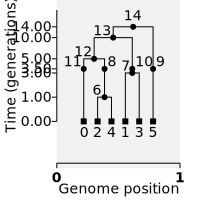

In [46]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=10)
demography.add_census(time=3.5)
ts = msprime.sim_ancestry({"A": 3}, demography=demography, model="dtwf", random_seed=33)
SVG(ts.draw_svg(y_axis=True, time_scale="log_time"))

## Manipulating simulation time

(sec_ancestry_end_time)=

### Stopping simulations early

In most simulations we want to simulate a complete history for our samples:
that is, to when we have a common ancestor at every point along the
sequence. For example, here we generate a complete ancestral history
for two diploid samples:

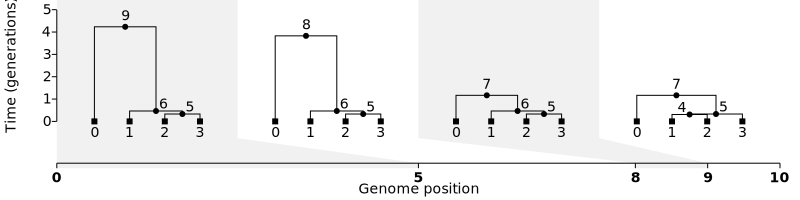

In [47]:
ts = msprime.sim_ancestry(2, sequence_length=10, recombination_rate=0.1, random_seed=42)
SVG(ts.draw_svg(y_axis=True, y_ticks=[0, 1, 2, 3, 4, 5]))

Sometimes we would like to stop the simulation early, **before** complete
coalescence has occurred; perhaps we would like to
{ref}`combine several simulations<sec_ancestry_initial_state_combining>`
with different properties, or we are really only interested in the
recent past and simulating more ancient processes would be a waste
of computational resources.

We can do this by specifying a ``end_time`` value.
Let's repeat the simulation as above with an ``end_time`` of 2:

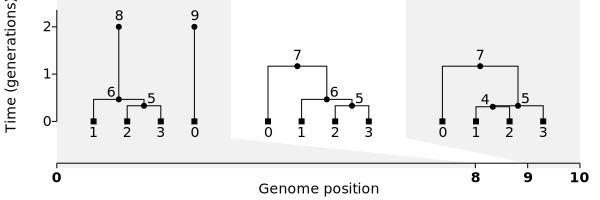

In [48]:
ts = msprime.sim_ancestry(
    2, sequence_length=10, recombination_rate=0.1, end_time=2, random_seed=42)
SVG(ts.draw_svg(y_axis=True, y_ticks=[0, 1, 2]))

There are a number of important things to observe about this
tree sequence:

1. The history up until time 2 is **identical** to the original simulation.
2. The first tree has not fully coalesced, and we therefore have **multiple
roots**. Trees with multiple roots are fully supported in tskit.
3. The nodes 8 and 9 are at time 2 (our ``end_time`` value), and these
connect to the uncoalesced portions of the tree. These "unary" nodes
are very important for ensuring the correct statistical properties
when we
{ref}`combine multiple simulations<sec_ancestry_initial_state_combining>`.

:::{seealso}
The ancestry model {ref}`duration<sec_ancestry_models_specifying_duration>`
can also be used to stop simulations before coalescence.
:::

For discrete time models, the exact interpretation
of the ``end_time`` is important --- we continue to simulate
the process while the time is <= ``end_time``. For example here
we use an ``end_time`` of 1 generation in a {ref}`sec_ancestry_models_dtwf`
simulation:

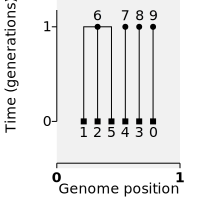

In [49]:
ts = msprime.sim_ancestry(3, population_size=10, model="dtwf", end_time=1, random_seed=42)
SVG(ts.draw_svg(y_axis=True))

We have run 1 generation of the DTWF, resulting in the coalescence
at node 9.


(sec_ancestry_start_time)=

### Setting the start time

:::{important}
Setting simulation start time is an advanced feature which is rarely
needed in practice.
:::

Sometimes we need control when the simulation process starts. For
example, given the initial configuration of at time zero we want to
"jump ahead" to a later time point before we start generating
random events. Consider the following example:

In [50]:
ts = msprime.sim_ancestry(2, random_seed=42)
ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,0,0.00000000,
1,1,0,0,0.00000000,
2,1,0,1,0.00000000,
3,1,0,1,0.00000000,
4,0,0,-1,0.15642269,
5,0,0,-1,0.29152170,
6,0,0,-1,2.11740681,


Now we run the same simulation with a ``start_time`` of 10:

In [51]:
ts = msprime.sim_ancestry(2, start_time=10, random_seed=42)
ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,0,0.00000000,
1,1,0,0,0.00000000,
2,1,0,1,0.00000000,
3,1,0,1,0.00000000,
4,0,0,-1,10.15642269,
5,0,0,-1,10.29152170,
6,0,0,-1,12.11740681,


We can see that the results are identical except that 10 has
been added to all of the internal node times.

:::{important}
It is important to note that the ``start_time`` only controls the
"random" events that happen within the simulation model: events
that are specified to occur at a given time (such as sampling
or demographic events) will occur at that time, even if this
is before the ``start_time``.
:::

Consider the following example in which we create a simple
{ref}`population tree<sec_demography_examples_population_tree>`
demography, and then take samples at different times all *before*
``start_time``:

In [52]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=100)
demography.add_population(name="B", initial_size=100)
demography.add_population(name="C", initial_size=100)
demography.add_population_split(time=5, derived=["A", "B"], ancestral="C")

ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(1, population="A", time=1),
        msprime.SampleSet(1, population="B", time=2),
        msprime.SampleSet(1, population="C", time=6),
    ],
    demography=demography,
    ploidy=1,
    start_time=10,
    random_seed=1)

ts.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,0,1.00000000,
1,1,1,1,2.00000000,
2,1,2,2,6.00000000,
3,0,2,-1,52.47084127,
4,0,2,-1,66.18169933,


We can see that the samples we specify are in the correct populations
and their node times are at the sampling time. Note that all the
coalescences happen in population ID 2 ("C"), indicating that the
lineages from "A" and "B" moved there at the time of the split
(which we can observe directly using the
{ref}`record_migrations<sec_ancestry_record_migrations>` option if we wish).
Note also that we drew a sample from population "C" at time 6,
which is {ref}`after<sec_demography_direction_of_time>` the split;
if we tried to draw a sample before the split, we would get an
error because the population would be
{ref}`inactive<sec_demography_populations_life_cycle>`.

:::{seealso}
See the {ref}`sec_ancestry_event_order` section for details
of the precise order in which fixed-time events occur.
:::

:::{note}
The same considerations apply when we are running simulations based
on a given {ref}`initial state<sec_ancestry_initial_state>`; in
this case, the ``start_time`` is by default set to the time
of the youngest root in the input trees.
:::

(sec_ancestry_event_order)=

### Order of event execution

There are two different classes of event that happen in ancestry
simulations: "fixed" and "random" events. Random events are
generated by the ancestry model, and fixed events are those
that occur at a time specified by the user. Fixed events
are {ref}`demographic events<sec_demography_events>` or
{ref}`sampling events<sec_ancestry_samples>`.
If multiple events are specified to occur at exactly the same time, then:

1. All demographic events at this time are run, *in the order they
were specified*.
2. Sampling events occur immediately after all the demographic events
have been executed. (See the {ref}`sec_ancestry_samples_sampling_time`
section for more details on ancient sampling events.)

These details are slightly different for the {ref}`sec_ancestry_models_dtwf`
model. See the {class}`API documentation<.DiscreteTimeWrightFisher>` for
details.

(sec_ancestry_initial_state)=

## Specifying the initial state

By default `msprime` simulations are initialised by specifying a set of
{ref}`samples<sec_ancestry_samples>`,
which sets up the simulation with segments of ancestral material covering the
whole sequence. Internally, this initial state is implemented by
setting up a {class}`tskit.TableCollection` which contains the
{ref}`population<tskit:sec_population_table_definition>`,
{ref}`node<tskit:sec_node_table_definition>`,
and {ref}`individual<tskit:sec_individual_table_definition>` information.
The low-level simulation code then reads these tables and sets up the
simulation accordingly. We can see what this initial state looks like
by setting up a simple simulation and stopping it immediately:

In [53]:
initial_ts = msprime.sim_ancestry(1, end_time=0)
initial_ts

We can see that the returned tree sequence has one population,
two sample nodes and one individual (since sample individuals are
{ref}`diploid<sec_ancestry_ploidy>` by default). There are no
{ref}`edges<tskit:sec_edge_table_definition>` because the simulation
didn't run for any period of time: we're essentially just returning
the initial state used to start the simulation.

Then, running a simulation in which the ``initial_state`` is equal to
``initial_ts`` is *precisely* the same as running the simulation
with the same arguments as we used above:

In [54]:
ts1 = msprime.sim_ancestry(initial_state=initial_ts, population_size=100, random_seed=2)
ts2 = msprime.sim_ancestry(1, population_size=100, random_seed=2)
assert ts1.equals(ts2, ignore_provenance=True)

:::{warning}
Note that the ``initial_state`` tree sequence only contains the
information about the ancestral histories, and not any of the
simulation parameters. In the previous example we used default
parameters to keep things simple, but in general the full
simulation model will need to be specified as well as the initial state.
In particular, see the {ref}`sec_ancestry_initial_state_demography` section.
:::

While it is possible to specify the initial state manually by
constructing the input tree sequence,
it is an advanced topic and rarely necessary. More often we are
interested in specifying the initial state of an ``msprime``
simulation using the output of *another* simulation.

:::{note}
The ``initial_state`` tree sequence is quite literally the initial
state of the tree sequence that is returned at the end of a simulation,
and that any information present (including metadata) will not be
altered.
:::

(sec_ancestry_initial_state_combining)=

### Combining backward-time simulations

Suppose that we wished to simulate a scenario
in which we have recombination happening at some rate in the recent past,
and in the more distant past there is no recombination.
We can do this by combining the simulations,
using one as the ``initial_state`` for the other.

We first run the simulation of the recent past:

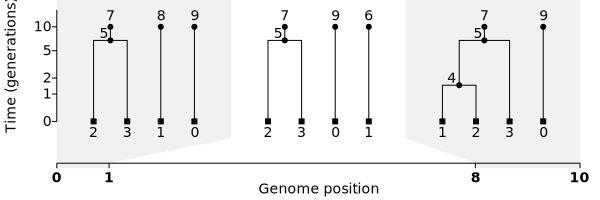

In [55]:
ts1 = msprime.sim_ancestry(
    2, recombination_rate=0.01, sequence_length=10, end_time=10,
    population_size=100, random_seed=1)
SVG(ts1.draw_svg(y_axis=True, time_scale="log_time", y_ticks=[0, 1, 2, 5, 10]))

Some recombination and coalescence has happened and we have three
marginal trees along the genome. None of these trees has fully coalesced,
and so each of the trees has multiple roots.

:::{important}
The set of nodes at time 10 connecting to all the internal nodes in the
trees are very important: without these nodes and unary edges, the
statistical properties of the combined simulations would not be correct!
(See also section below on
{ref}`forward simulations<sec_ancestry_initial_state_forward_simulations>`.)
:::

We then run the next phase of the simulation in which there is
*no* recombination by passing ``ts1`` as the argument to ``initial_state``:

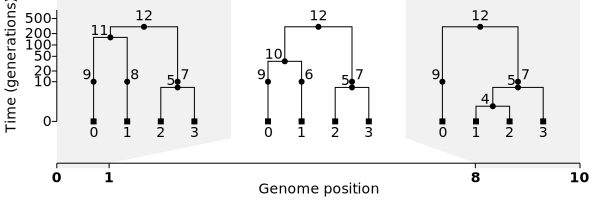

In [56]:
ts2 = msprime.sim_ancestry(initial_state=ts1, population_size=100, random_seed=3)
SVG(ts2.draw_svg(y_axis=True, time_scale="log_time", y_ticks=[0, 10, 20, 50, 100, 200, 500]))

Since there is no recombination in this more ancient simulation,
node ``12`` is the MRCA in all three trees. The unary nodes
``6``, ``7``, ``8``, and ``9`` marking the transition between the
two simulation regimes are still present in the trees. If you
wish to remove these, we can use the {meth}`tskit.TreeSequence.simplify`
method:

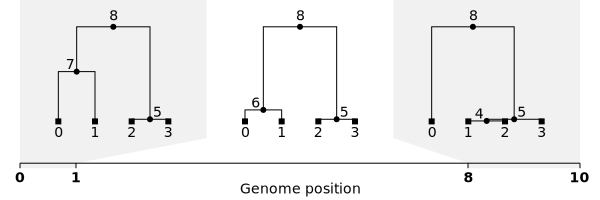

In [57]:
ts_simplified = ts2.simplify()
SVG(ts_simplified.draw_svg())

(sec_ancestry_initial_state_demography)=

### Interaction with demography

In the previous example we saw how to combine two single population simulations.
We can also combine more complex simulations involving
{ref}`demography<sec_demography>`, but care needs to be taken to ensure that
the correct models are simulated in each part of the simulation.
Suppose we have simple model with a
{ref}`population split<sec_demography_events_population_split>`:

In [58]:
demography = msprime.Demography()
demography.add_population(name="A", description="Contemporary population A", initial_size=100)
demography.add_population(name="B", description="Contemporary population B", initial_size=200)
demography.add_population(name="C", description="Ancestral population", initial_size=300)
demography.add_population_split(time=100, ancestral="C", derived=["A", "B"])
demography

Demography(populations=[Population(initial_size=100, growth_rate=0, name='A', description='Contemporary population A', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=200, growth_rate=0, name='B', description='Contemporary population B', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=300, growth_rate=0, name='C', description='Ancestral population', extra_metadata={}, default_sampling_time=100, initially_active=False, id=2)], events=[PopulationSplit(time=100, derived=['A', 'B'], ancestral='C')], migration_matrix=array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]))

Then, we run a simulation of this model for 50 generations:

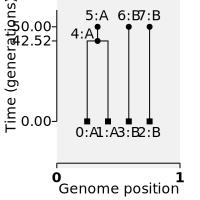

In [59]:
ts1 = msprime.sim_ancestry(
    samples={"A": 1, "B": 1}, demography=demography, end_time=50, random_seed=1234)
node_labels = {
    node.id: f"{node.id}:{ts1.population(node.population).metadata['name']}"
    for node in ts1.nodes()}
SVG(ts1.draw_svg(node_labels=node_labels, y_axis=True))

After 50 generations we can see there has been a coalescence in population ``A``
but none in ``B`` and we therefore have three lineages left when the simulation
finishes. We can then continue the simulation based on this initial state:

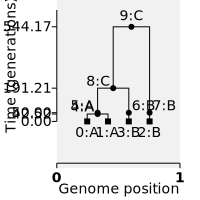

In [60]:
ts2 = msprime.sim_ancestry(
    initial_state=ts1, demography=demography, random_seed=5678)
node_labels = {
    node.id: f"{node.id}:{ts2.population(node.population).metadata['name']}"
    for node in ts2.nodes()}
SVG(ts2.draw_svg(node_labels=node_labels, y_axis=True))

Note that we use the **same** demography object, and so the lineages
migrate and ultimately coalesce in population ``C``, as we'd expect.
This is the simplest case, in which we already have the demography
object which we can use to model the entire simulation from end-to-end.

In other cases (e.g. when working with simulations from a different
program), we don't have the {class}`.Demography` object at hand
and we need to create one that is both compatible with the
``initial_state`` tree sequence and reflects the demographic
model that we are interested in using. The best way to do this
is to use the {meth}`.Demography.from_tree_sequence` method to
first get a base demography that is based on the
tree sequence {ref}`population table<tskit:sec_population_table_definition>`
and {ref}`metadata<tskit:sec_metadata>`:

In [61]:
demography = msprime.Demography.from_tree_sequence(ts1)
demography

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,A,Contemporary population A,0.0,0,0,{}
1,B,Contemporary population B,0.0,0,0,{}
2,C,Ancestral population,0.0,0,0,{}


We can see that the population names and descriptions have been recovered
from the tree sequence metadata but **no other information**: the
population sizes are all zero and we no longer have a population split
event. If we try to run a simulation using this demography we get an
error:

In [62]:
ts = msprime.sim_ancestry(initial_state=ts1, demography=demography)

InputError: Input error in initialise: Attempt to sample lineage in a population with size=0

To recover the original model we must update the {class}`.Population`
objects in place and add the
{ref}`population split<sec_demography_events_population_split>` event:

In [63]:
demography["A"].initial_size = 100
demography["B"].initial_size = 200
demography["C"].initial_size = 300
demography.add_population_split(time=100, ancestral="C", derived=["A", "B"])
demography

Demography(populations=[Population(initial_size=100, growth_rate=0, name='A', description='Contemporary population A', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=200, growth_rate=0, name='B', description='Contemporary population B', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=300, growth_rate=0, name='C', description='Ancestral population', extra_metadata={}, default_sampling_time=100, initially_active=False, id=2)], events=[PopulationSplit(time=100, derived=['A', 'B'], ancestral='C')], migration_matrix=array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]))

:::{note}
See the {class}`.Demography` documentation for details on how to access
{class}`.Population` objects.
:::

The demography that we obtain from {meth}`.Demography.from_tree_sequence`
is really just a template, which we update and elaborate as we need.
In particular, we are free to add more populations as needed.

(sec_ancestry_initial_state_forward_simulations)=

### Continuing forwards-time simulations ("recapitating")

The most common use for the ``initial_state`` argument is to
start the simulation from the output of a forwards-time simulation.
Informally, we take an 'unfinished'
tree sequence as a parameter to {func}`.sim_ancestry`, initialise the simulation
from the state of this tree sequence and then run the simulation until
coalescence. The returned tree sequence is then the result of taking the
input tree sequence and completing the trees using the coalescent.

This is useful for forwards-time simulators such as
[SLiM](https://messerlab.org/slim/) and
[fwdpy11](https://pypi.org/project/fwdpy11/)
that can output tree sequences. By running
forward-time simulation for a certain number of generations we obtain a
tree sequence, but these trees may not have had sufficient time to
reach a most recent common ancestor. By using the `initial_state` argument
to {func}`.sim_ancestry` we can combine the best of both forwards- and
backwards-time simulators. The recent past can be simulated forwards
in time and the ancient past by the coalescent. The coalescent
simulation is initialised by the root segments of the
input tree sequence, ensuring that the minimal amount of ancestral
material possible is simulated.

Any tree sequence can be provided as input to this process, but there is a
specific topological requirement that must be met for the simulations to be
statistically correct. To ensure that ancestral segments are correctly
associated within chromosomes when constructing the initial conditions for the
coalescent simulation, forward-time simulators **must** retain the nodes
corresponding to the initial generation. Furthermore, for every sample in the
final generation (i.e. the extant population at the present time) there must be
a path to one of the founder population nodes.

:::{seealso}
See the {ref}`recapitation tutorial<pyslim:sec_tutorial_recapitation>`
from the [pyslim](https://github.com/tskit-dev/pyslim) documentation
for a detailed explanation of this process when
using [SLiM](https://messerlab.org/slim/).
:::

(sec_ancestry_models)=

## Models

The ancestry model determines the model under which the ancestral
history of the sample is generated. It is concerned with the
basic processes of how (for example) common ancestor and
recombination events occur. For example, the default
"standard" or {ref}`sec_ancestry_models_hudson` is an
efficient continuous time model, and the
{ref}`sec_ancestry_models_dtwf` model allows
for more detailed (if less efficient) simulations by
making fewer mathematical approximations.
We can combine multiple ancestry models in a simulation
using a flexible {ref}`notation<sec_ancestry_models_specifying>`.

:::{seealso}
See the {ref}`sec_ancestry_quickref` for a summary of the available
ancestry models
:::

:::{important}
The ancestry model is distinct from the {ref}`demographic model<sec_demography>`,
which is mostly independent of the chosen ancestry model.
:::

(sec_ancestry_models_specifying)=

### Specifying ancestry models

The ancestry models used during a simulation are specified using
the ``model`` parameter to {func}`.sim_ancestry`. Each model is a
subclass of the {class}`.AncestryModel` class (see the following
subsections for the available models, and examples of their usage).

#### Single models

Most of the time we want to run a simulation under a single
ancestry model. By default, we run simulations under the
{class}`.StandardCoalescent` model. If we wish to run
under a different model, we use the ``model`` argument to
{func}`.sim_ancestry`. For example, here we use the
{class}`SMC<.SmcApproxCoalescent>` model instead of the
standard coalescent:

In [64]:
ts1 = msprime.sim_ancestry(
    10,
    sequence_length=10,
    recombination_rate=0.1,
    model=msprime.SmcApproxCoalescent(),
    random_seed=1234)

We specify the model as an instance of one of the ancestry model classes.
For nonparametric models, there is also a useful shorthand
of the model name:

In [65]:
ts2 = msprime.sim_ancestry(
    10,
    sequence_length=10,
    recombination_rate=0.1,
    model="smc",
    random_seed=1234)
assert ts1.equals(ts2, ignore_provenance=True)

This string form is useful for single model simulations;
however, when working with
{ref}`sec_ancestry_models_specifying_multiple` it is better to use
the explicit class form so that the
{ref}`sec_ancestry_models_specifying_duration` can be set.

(sec_ancestry_models_specifying_duration)=

#### Model duration

Each ancestry model instance has a {attr}`~.AncestryModel.duration` associated
with it. This is the maximum amount of time that this model can run for. Thus,
if we wanted to run 10 generations of the {class}`.DiscreteTimeWrightFisher`
model we could write:

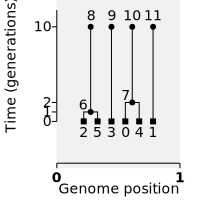

In [66]:
ts = msprime.sim_ancestry(
    3,
    population_size=10,
    model=msprime.DiscreteTimeWrightFisher(duration=10),
    random_seed=1234)
SVG(ts.draw_svg(y_axis=True))

:::{note}
Using the duration value for a single model like this is identical to
specifying an ``end_time`` value: see the {ref}`sec_ancestry_end_time`
section for more information.
:::

It is vital to understand that the ``duration`` value here is **not**
an absolute time at which the simulation must stop, but rather
the number of generations that the model should run for. To illustrate
this we can use the {ref}`start_time<sec_ancestry_start_time>` parameter:

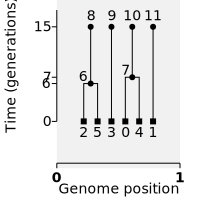

In [67]:
ts = msprime.sim_ancestry(
    3,
    population_size=10,
    start_time=5,
    model=msprime.DiscreteTimeWrightFisher(duration=10),
    random_seed=1234)
SVG(ts.draw_svg(y_axis=True))

We can see that the simulation continued until 15 generations ago,
because it didn't start until 5 generations ago and we then specified
that the model should run for at most 10 generations.

The model activity time is specified as a duration in this way
as this is a natural way to specify
{ref}`sec_ancestry_models_specifying_multiple`, in which
some of the models may run for random periods of time.


(sec_ancestry_models_specifying_completion)=

#### Model completion

Most ancestry models will run until the overall simulation has
completed; that is, when we have simulated back to the most
recent common ancestor at every position along the sequence.
For example, the {class}`.StandardCoalescent` and
{class}`.DiscreteTimeWrightFisher` models will simulate
until coalescence, unless we explicitly indicate that we wish
to stop the simulation early via the
{ref}`model duration<sec_ancestry_models_specifying_duration>`
or the {ref}`end_time<sec_ancestry_end_time>` parameter.

Models such as {class}`.SweepGenicSelection` are different though:
they are only defined for a limited amount of time and
may not run until coalescence (see the
{ref}`sec_ancestry_models_selective_sweeps`
for more information on the model itself).

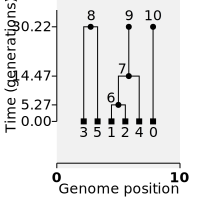

In [68]:
sweep = msprime.SweepGenicSelection(
    position=5,
    start_frequency=0.1,
    end_frequency=0.9,
    s=0.25,
    dt=1e-6,
)
ts = msprime.sim_ancestry(
    3,
    sequence_length=10,
    population_size=100,
    model=sweep,
    random_seed=1234)
SVG(ts.draw_svg(y_axis=True))

Here, we see that even though we didn't specify
a {ref}`model duration<sec_ancestry_models_specifying_duration>`
or {ref}`end_time<sec_ancestry_end_time>` parameter the simulation
has ended before we reached coalescence. In addition, the
model duration is **random**:

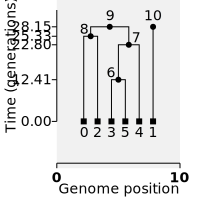

In [69]:
ts = msprime.sim_ancestry(
    3,
    sequence_length=10,
    population_size=100,
    model=sweep,
    random_seed=12345)
SVG(ts.draw_svg(y_axis=True))

Here we ran the same simulation with a different random seed, and
we can see that the time the model completed was different in
the two cases (30.22 vs 28.15 generations ago).

:::{note}
Models such as {class}`.SweepGenicSelection` can also complete due
to full coalescence.
:::

(sec_ancestry_models_specifying_multiple)=

#### Multiple models

Sometimes we are interested in combining different models in a simulation.
To do this we provide a **list** of ancestry model instances as the
``model`` argument to {func}`.sim_ancestry`. The models
are run in the order they are specified. For each model, if its
{attr}`~.AncestryModel.duration` is set, then the simulation will run
for at most that additional time duration. If the ``duration`` is
not set (or ``None``), then the model will run until
{ref}`completion<sec_ancestry_models_specifying_completion>`.


For example, here we run a hybrid DTWF and coalescent
simulation (see the {ref}`sec_ancestry_models_dtwf` section for more
details):

In [70]:
ts = msprime.sim_ancestry(
    2,
    population_size=1000,
    model=[
        msprime.DiscreteTimeWrightFisher(duration=500),
        msprime.StandardCoalescent(),
    ],
    random_seed=2
)

:::{warning}
It is very imporant to remember to set a ``duration`` value in the first
model here! Otherwise, the entire simulation will run under the DTWF model.
:::

In this example we've run the {class}`.DiscreteTimeWrightFisher`
model for the first 500 generations, and then switched to the
{class}`.StandardCoalescent`. Because we did not specify a
``duration`` in the second model, it will run until coalescence.

:::{note}
Switching models at a fixed time point like this is equivalent to
first running the DTWF phase of the simulation with ``end_time=500``
and then using the output as the
{ref}`initial state<sec_ancestry_initial_state>` for the simulation
of the Hudson phase. The model switching syntax here is a little
more convenient and efficient, however.
:::

:::{seealso}
See the {ref}`sec_ancestry_models_selective_sweeps_multiple` section for
an example of running many models with random durations.
:::

:::{tip}
The logging output of msprime can be very useful when working with
multiple models. See the {ref}`sec_logging` section for more
details.
:::

(sec_ancestry_models_hudson)=

### Hudson coalescent

The {class}`standard coalescent<.StandardCoalescent>`
is the default model in msprime. The algorithm
for simulating the coalescent with recombination was developed
by [Hudson (1983)](https://doi.org/10.1016/0040-5809(83)90013-8),
and so we refer to it as the "Hudson" coalescent.

Running a simulation without specifying a ``model`` is the
same as running with ``model="hudson"``:

In [71]:
ts1 = msprime.sim_ancestry(5, random_seed=2)
ts2 = msprime.sim_ancestry(5, model="hudson", random_seed=2)
# This is the same simulation so tree sequences are equal
assert ts1.equals(ts2, ignore_provenance=True)

Time is measured in units of generations ago. This is a continuous time
model, in which the simulation moves event-by-event backwards
in time (contrasting with the {ref}`sec_ancestry_models_dtwf` model, which
works generation-by-generation). Thus, we can have fractional
generations, as in this example where the MRCA of the sample
occurs 10.59 "generations" ago:

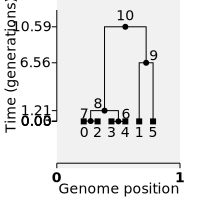

In [72]:
ts = msprime.sim_ancestry(3, random_seed=234)
SVG(ts.draw_svg(y_axis=True))

This occurs because time is scaled to be proportional to
the population size; if we run the same simulation with a
different {ref}`population size<sec_ancestry_demography>`, we can see that
the time values are simply scaled up accordingly
(the default ``population_size`` is 1):

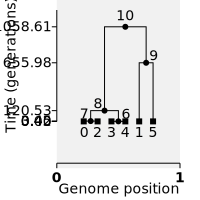

In [73]:
ts = msprime.sim_ancestry(3, population_size=100, random_seed=234)
SVG(ts.draw_svg(y_axis=True))

:::{seealso}
The {ref}`ploidy<sec_ancestry_ploidy>` parameter also controls
the time scale; the
default here is the diploid time scale where time is measured
in units of 4N generations.
:::

(sec_ancestry_models_smc)=

### SMC approximations

The {class}`SMC <.SmcApproxCoalescent>` and {class}`SMC' <.SmcPrimeApproxCoalescent>`
are approximations of the continuous time
{ref}`Hudson coalescent<sec_ancestry_models_hudson>` model. These were originally
motivated largely by the need to simulate coalescent processes more efficiently
than was possible using the software available at the time; however,
[improved algorithms](https://doi.org/10.1371/journal.pcbi.1004842)
mean that such approximations are now mostly unnecessary for simulations.

The SMC and SMC' are however very important for inference, as the approximations
have made many analytical advances possible.

Since the SMC approximations are not required for simulation efficiency, these
models are implemented using a naive rejection sampling approach in msprime.
The implementation is intended to facilitate the study of the
SMC approximations, rather than to be used in a general-purpose way.

(sec_ancestry_models_dtwf)=

### Discrete Time Wright-Fisher

Msprime provides the option to perform discrete-time Wright-Fisher (DTWF)
simulations for scenarios when the coalescent model is not appropriate, including large
sample sizes, multiple chromosomes, or recent migration.
Please see the {class}`API documentation<.DiscreteTimeWrightFisher>`
for a formal description of the model,
and [Nelson et al. 2020](https://doi.org/10.1371/journal.pgen.1008619) for
more details and background information.

To run DTWF simulations, we need to provide the ``model="dtwf"`` argument
to {func}`.sim_ancestry`:

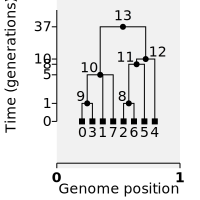

In [74]:
ts = msprime.sim_ancestry(4, population_size=10, model="dtwf", random_seed=7)
SVG(ts.draw_svg(y_axis=True, time_scale="log_time"))

There are a few important points to note here:

1. All node times are integers (this is discrete time counted in generations);
2. We can have **non-binary** nodes (see node 10);
3. We can have **simultaneous** events (see nodes 8 and 9).

Most features can be used with the DTWF model, and an error will be raised if
you attempt to use a feature that is not implemented for DTWF. (Please let
us know if this feature is important to you!)

:::{important}
For DTWF simulations with population structure, each row of the migration
matrix must sum to one or less.
:::

Because DTWF simulations trace the history of a sample by going backwards
in time generation-by-generation rather than event-by-event like the
continuous time models, it is significantly slower to simulate than
the standard coalescent.

"Hybrid" simulations can be a good solution if DTWF simulations are
slow. In this case we can use DTWF simulations for the recent past, and using
the standard coalescent for the more distant past (where it is an excellent
approximation of the discrete time model). Hybrid simulations
of this type provide the best of computational efficiency and accuracy.

:::{seealso}
See [Nelson et al. 2020](https://doi.org/10.1371/journal.pgen.1008619) for
more details and examples where the DTWF model is more realistic than
the coalescent, and an assessment of the accuracy of hybrid simulations.
:::

For example, here we simulate with the DTWF model for 500 generations,
before switching to the standard (Hudson) coalescent:

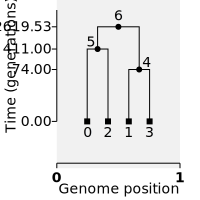

In [75]:
ts = msprime.sim_ancestry(
    2,
    population_size=1000,
    model=[
        msprime.DiscreteTimeWrightFisher(duration=500),
        msprime.StandardCoalescent(),
    ],
    random_seed=4
)
SVG(ts.draw_svg(y_axis=True, time_scale="log_time"))

Because of the integer node times, we can see here that most of the coalescent
happened during the Wright-Fisher phase of the simulation, and as-of 500
generations in the past, there were only two lineages left. The continuous
time standard coalescent model was then used to simulate the ancient past of
these two lineages.

See the {ref}`sec_ancestry_models_specifying` section for more details on
how the use the ``model`` argument to {func}`.sim_ancestry` to run
multiple models.

:::{seealso}
See the {ref}`sec_ancestry_multiple_chromosomes` section for information
on how to simulate multiple chromosomes using the DTWF.
:::


(sec_ancestry_models_multiple_mergers)=

### Multiple merger coalescents

Some evolutionary scenarios, such as a skewed offspring distribution
combined with a type III survivorship curve, range expansion, and
rapid adaptation, can predict genealogies with up to four simultaneous
multiple mergers. Msprime provides the option to simulate from two classes
of such genealogical processes: the {class}`.BetaCoalescent` and
the {class}`.DiracCoalescent`. Please see the API documentation for formal
details of the models.

For haploid organisms, both models result in genealogies in which
any number of lineages can merge into a common ancestor,
but only one merger event can take place at a given time. For {math}`p`-ploids,
up to {math}`2p` simultaneous mergers can take place, corresponding to the
{math}`2p` available parental chromosome copies.

The diploid Beta-Xi-coalescent can be simulated as follows:

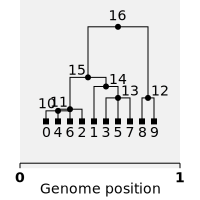

In [76]:
ts = msprime.sim_ancestry(
    samples=5, ploidy=2, random_seed=1,
    model=msprime.BetaCoalescent(alpha=1.001))
SVG(ts.draw_svg())


The specified value of {math}`\alpha = 1.001` corresponds to a heavily skewed
offspring distribution. Values closer to {math}`\alpha = 2` result in trees
whose distribution is closer to that of the standard coalescent, often featuring
no multiple mergers for small sample sizes:

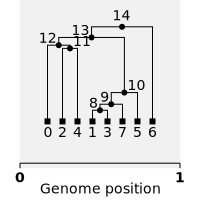

In [77]:
ts = msprime.sim_ancestry(
    samples=4, ploidy=2, random_seed=1,
    model=msprime.BetaCoalescent(alpha=1.8))
SVG(ts.draw_svg())


Multiple mergers still take place in a haploid simulation, but only one merger
can take place at a given time:

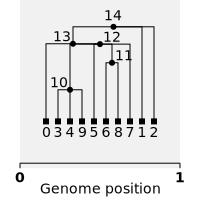

In [78]:
ts = msprime.sim_ancestry(
    samples=10, ploidy=1, random_seed=1,
    model=msprime.BetaCoalescent(alpha=1.001))
SVG(ts.draw_svg())


A haploid simulation results in larger individual mergers than a polyploid simulation
because large mergers typically get broken up into multiple simultaneous mergers
in the polyploid model.

The number of generations between merger events in the Beta-coalescent depends
nonlinearly on both {math}`\alpha` and the population size {math}`N`
as detailed above.
For a fixed {math}`\alpha`, the number of generations between common ancestor events
is proportional to {math}`N^{\alpha - 1}`, albeit with a complicated constant of
proportionality that depends on {math}`\alpha`. The dependence on {math}`\alpha`
for fixed {math}`N` is not monotone. Thus, branch lengths and the number of
generations until a most recent common ancestor depend on both of these parameters.

To illustrate, for {math}`\alpha` close to 2 the relationship between effective
population size and number of generations is almost linear:

In [79]:
ts = msprime.sim_ancestry(
    samples=1, ploidy=2, random_seed=1, population_size=10,
    model=msprime.BetaCoalescent(alpha=1.99))
tree = ts.first()
print(tree.tmrca(0,1))
ts = msprime.sim_ancestry(
    samples=1, ploidy=2, random_seed=1, population_size=1000,
    model=msprime.BetaCoalescent(alpha=1.99))
tree = ts.first()
print(tree.tmrca(0,1))


0.14959691919068155
14.286394871874865


For {math}`\alpha` close to 1 the effective population size has little effect:

In [80]:
ts = msprime.sim_ancestry(
    samples=1, ploidy=2, random_seed=1, population_size=10,
    model=msprime.BetaCoalescent(alpha=1.1))
tree = ts.first()
print(tree.tmrca(0,1))
ts = msprime.sim_ancestry(
    samples=1, ploidy=2, random_seed=1, population_size=1000,
    model=msprime.BetaCoalescent(alpha=1.1))
tree = ts.first()
print(tree.tmrca(0,1))


16.311807036386615
25.85247192870844


The Dirac-coalescent is simulated similarly in both the diploid case:

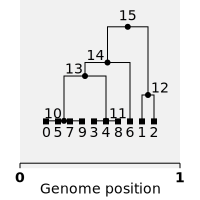

In [81]:
ts = msprime.sim_ancestry(
    samples=5, ploidy=2, random_seed=1,
    model=msprime.DiracCoalescent(psi=0.9, c=10))
SVG(ts.draw_svg())


and in the haploid case:

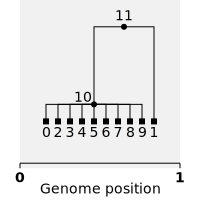

In [82]:
ts = msprime.sim_ancestry(
    samples=10, ploidy=1, random_seed=1,
    model=msprime.DiracCoalescent(psi=0.9, c=10))
SVG(ts.draw_svg())


As with the Beta-coalescent, a haploid simulation results in larger individual
mergers than a polyploid simulation because large mergers typically get broken
up into multiple simultaneous mergers in the polyploid model. Larger values
of the parameter {math}`c > 0` result in more frequent multiple mergers,
while larger values of {math}`0 < \psi \leq 1` result in multiple mergers
with more participating lineages. Setting either parameter to 0 would correspond
to the standard coalescent.

The Dirac-coalescent is obtained as the infinite population scaling limit of
Moran models, and therefore branch lengths are proportional to {math}`N^2`
generations, as opposed to {math}`N` generations under the standard coalescent.

In [83]:
ts = msprime.sim_ancestry(
    samples=1, ploidy=2, random_seed=1, population_size=10,
    model=msprime.DiracCoalescent(psi=0.1, c=1))
tree = ts.first()
print(tree.tmrca(0,1))
ts = msprime.sim_ancestry(
    samples=1, ploidy=2, random_seed=1, population_size=100,
    model=msprime.DiracCoalescent(psi=0.1, c=1))
tree = ts.first()
print(tree.tmrca(0,1))


64.7216732891741
6472.167328917411


Because branch lengths are proportional to {math}`N^2` generations, the number
of events simulated along branches (such as mutations or recombinations) will
also be proportional to {math}`N^2`. For example, if a tree sequence generated
using a given census size {math}`N` is used as input for simulating segregating
sites (see {ref}`Mutation simulations<sec_mutations>` for details on how to do
this), the expected number of segregating sites obtained will be proportional
to {math}`N^2`.

In [84]:
ts = msprime.sim_ancestry(
    samples=1, ploidy=2, random_seed=1, population_size=10000,recombination_rate=1e-8,
    sequence_length=10**4,model=msprime.DiracCoalescent(psi=0.1, c=0))
mts = msprime.sim_mutations(ts, rate=1e-8)
print(str(mts.get_num_sites()))

6652


If the desired amount of diversity (as measured by the number of segregating
sites) is proportional to {math}`N`, then {math}`N^{1/2}` should be used for
the population size under the Dirac-coalescent.

In [85]:
ts = msprime.sim_ancestry(
    samples=1, ploidy=2, random_seed=1, population_size=100,recombination_rate=1e-8,
    sequence_length=10**4,model=msprime.DiracCoalescent(psi=0.1, c=0))
mts = msprime.sim_mutations(ts, rate=1e-8)
print(str(mts.get_num_sites()))

1


Therefore the population size must be carefully chosen (and
potentially rescaled) to obtain the desired simulated data in these models.

(sec_ancestry_models_selective_sweeps)=

### Selective sweeps

Although the coalescent assumes that lineages are exchangable, (and therefore
evolving neutrally), approximations to some forms of selective sweep
(beneficial mutation moves through the population), have been derived. This is
done through the use of a structured coalescent model in the spirit of
[Braverman et al. (1995)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1206652/).

In the {class}`.SweepGenicSelection` model,
the population is split between two classes of selective backgrounds,
those linked to the beneficial allele, call it {math}`B`, and those not,
{math}`b`. In this model we track competing
rates of coalescence and recombination on the {math}`B` and {math}`b`
backgrounds.
The user supplies a final allele frequency and a starting
allele frequency, between which msprime simulates a stochastic
sweep trajectory according to a conditional diffusion model [(Coop
and Griffiths, 2004](https://pubmed.ncbi.nlm.nih.gov/15465123/);
[Kim and Stephan 2002](https://pubmed.ncbi.nlm.nih.gov/11861577/)).

Beyond the start and end frequencies of the sweep trajectory, the user
must specify the selection coefficient of the beneficial mutation
{math}`s` the selective
advantage of the {math}`B` homozygote over the {math}`b` homozygote
and {math}`h=0.5`. The position represents the location along
the chromosome where the beneficial allele occurs.
All other parameters can be set as usual.

:::{warning}
The implementation of the structured coalescent is quite general, but there are
some limitations in the current implementation of the sweeps model (e.g., no
change of population size during a sweep). Please let us know if there are
related features you would like to see (or if you would be interested in
helping to create this functionality!)
:::


#### Hard sweeps

:::{todo}
What's a hard sweep? Some intro sentences here.
:::

In this example we run some replicate hard sweep simulations
and plot the mean
{meth}`pairwise diversity<tskit.TreeSequence.diversity>` in windows
across the simulated region, showing the characteristic
valley of diversity.

First we set up some basic parameters, and define the sweep model:

In [86]:
Ne = 1e3
L = 1e6  # Length of simulated region
num_reps = 100

# define hard sweep model
sweep_model = msprime.SweepGenicSelection(
    position=L / 2,  # middle of chrom
    start_frequency=1.0 / (2 * Ne),
    end_frequency=1.0 - (1.0 / (2 * Ne)),
    s=0.25,
    dt=1e-6,
)

:::{todo}
Explain why these parameters give a hard sweep.
:::

Next we set up the replicate simulations. As described
in the {ref}`sec_ancestry_models_specifying_multiple` section,
the ``model`` parameter is a list when we want to run multiple
ancestry models. In this example, we have a sweep that occurs
in the immediate past, and is then followed by the
standard coalescent for the rest of time:

In [87]:
reps = msprime.sim_ancestry(
    5,
    model=[sweep_model, msprime.StandardCoalescent()],
    population_size=Ne,
    recombination_rate=1e-7,
    sequence_length=L,
    num_replicates=num_reps,
)

:::{note}
Because the {class}`.SweepGenicSelection` model has a random
{ref}`duration<sec_ancestry_models_specifying_duration>` we do
not set this value in the model. Please see the
{ref}`sec_ancestry_models_specifying_completion` section for
more discussion on this important point.
:::

Once we've set up the replicate simulations we can compute the
windows for plotting, run the actual simulations
(see the {ref}`sec_randomness_replication` section for more details)
and compute the
{meth}`pairwise diversity<tskit.TreeSequence.diversity>`.

In [88]:
wins = np.linspace(0, L, 21)
mids = (wins[1:] + wins[:-1]) / 2
diversity = np.zeros((num_reps, mids.shape[0]))
for j, ts in enumerate(reps):
    diversity[j] = ts.diversity(windows=wins, mode="branch")

Finally, we can plot the observed mean diversity across the replicates
and compare it to the neutral expectation:

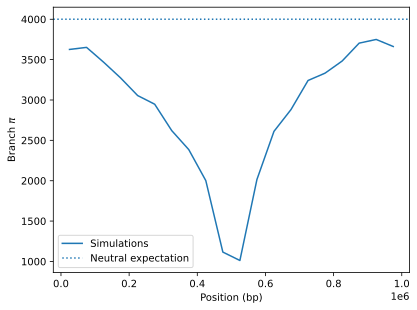

In [89]:
from matplotlib import pyplot as plt

plt.plot(mids, diversity.mean(axis=0), label="Simulations")
plt.axhline(4 * Ne, linestyle=":", label=r'Neutral expectation')
plt.ylabel(r'Branch $\pi$');
plt.xlabel('Position (bp)')
plt.legend();

:::{note}
We use the "branch" measure of pairwise diversity which is
defined in terms of the trees rather than nucleotide sequences. See
[Ralph et al. 2020](https://doi.org/10.1534/genetics.120.303253)
for more information.
:::

As we can see, the selective sweep has reduced variation in the region
most closely linked to the beneficial allele and then diversity
increases with distance to each side.

(sec_ancestry_models_selective_sweeps_multiple)=

#### Multiple sweeps

:::{todo}
This example is very artificial; it would be much better to illustrate
with a meaningful example from the literature. Pull requests welcome!
:::

To illustrate the idea that we can simulate large numbers of different
models, in this example we create a simulation in which we have
sweeps happening at random points along the genome, which
are separated by a random duration of the standard coalescent.

First we set up our models:

In [90]:
import random
random.seed(1234)
L = 100
Ne = 1e6

models = []
for _ in range(100):
    models.append(msprime.StandardCoalescent(duration=random.uniform(0, 1)))
    models.append(
        msprime.SweepGenicSelection(
            position=random.randint(1, L - 1),
            start_frequency=1 / (2 * Ne),
            end_frequency=1.0 - 1 / (2 * Ne),
            s=0.01,
            dt=1e-6,
        )
    )
models.append(msprime.StandardCoalescent())
models[:5]

[StandardCoalescent(duration=0.9664535356921388),
 SweepGenicSelection(duration=None, position=57, start_frequency=5e-07, end_frequency=0.9999995, s=0.01, dt=1e-06),
 StandardCoalescent(duration=0.11685051774599753),
 SweepGenicSelection(duration=None, position=12, start_frequency=5e-07, end_frequency=0.9999995, s=0.01, dt=1e-06),
 StandardCoalescent(duration=0.9109759624491242)]

We've created a list of models that have random parameters using the
standard Python tools. There are lots of sweeps (many more than we
will actually run, in all probability), each at a random position
on the genome and each separated by a random amount of time running
the standard coalescent. Finally, we add an instance of the standard
coalescent without a {ref}`duration<sec_ancestry_models_specifying_duration>`
to guarantee that our simulation will always coalesce fully
(See the {ref}`sec_ancestry_models_specifying_completion` section
for more information.) Finally, we print out the first 5 models
so we can inspect them.

Then, we can run our simulation as usual:

In [91]:
ts = msprime.sim_ancestry(
    10,
    population_size=100,
    sequence_length=L,
    recombination_rate=0.01,
    model=models,
    random_seed=6789
)
ts

:::{tip}
The logging output of msprime can be very useful when working with
multiple models. See the {ref}`sec_logging` section for more
details.
:::

(sec_ancestry_models_fixed_pedigree)=

### Fixed pedigree

A pedigree describes parent-offspring relationships between individuals, and
these relationships constrain how genomes are inherited. We can simulate
ancestry conditioned on a fixed pedigree using the {class}`.FixedPedigree`
ancestry model. In this model the transfer of genetic material from parent to
offspring is determined by the pedigree. Recombination occurs randomly such that
each of a diploid individual's two genomes is a mixture of two corresponding
parental genomes, but everything else is determined by the pedigree.

:::{warning}
It is important to note that there is no concept of a population genetic
model "outside" of the pedigree in this model, and there
are significant caveats when dealing with incomplete pedigree information
and the treatment of founders.
Please see the {ref}`sec_ancestry_models_fixed_pedigree_completing`
section for more information.
:::

#### Simple example

First we define a small pedigree, which follows a sample of three
individuals through four generations:

```{seealso}
See the {ref}`sec_pedigrees` section for details on this pedigree
text format and information on how pedigrees are encoded in msprime
via the individual and node tables.
```

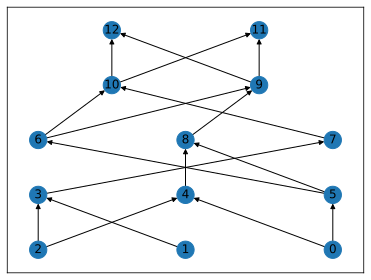

In [92]:
import io
ped_txt = """\
# id parent0 parent1 time is_sample
0   5   4   0.0 1
1   3   3   0.0 1
2   3   4   0.0 1
3   7   7   1.0 0
4   8   8   1.0 0
5   8   6   1.0 0
6   9   10  2.0 0
7   10  10  2.0 0
8   9   9   2.0 0
9   11  12  3.0 0
10  11  12  3.0 0
11  .   .   4.0 0
12  .   .   4.0 0
"""
pedigree = msprime.parse_pedigree(io.StringIO(ped_txt), sequence_length=100)

draw_pedigree(pedigree.tree_sequence())

:::{note} See the {ref}`sec_pedigrees_visualisation` section for a
definition of the ``draw_pedigree`` function used here.
:::

We then use this pedigree information as the
{ref}`initial state<sec_ancestry_initial_state>` for the simulation
(note that we set the sequence length on the pedigree tables
when we called {func}`.parse_pedigree`):

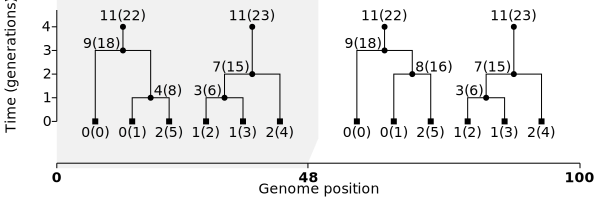

In [93]:
ped_ts = msprime.sim_ancestry(
    initial_state=pedigree, model="fixed_pedigree", random_seed=41,
    recombination_rate=0.001)
node_labels = {node.id: f"{node.individual}({node.id})" for node in ped_ts.nodes()}
SVG(ped_ts.draw_svg(y_axis=True,  node_labels=node_labels, size=(600,200)))

The output tree sequence contains the simulated genetic ancestry conditioned
on this input pedigree, as shown in the trees above. Each node is labelled
with it the individual ID it's associated with, and its ID (as individual(node)).
The simulation stops at time 4, and we are left with multiple
roots, which correspond to the founder individuals. If you only
need simulations of the genetic ancestry through the pedigree,
then these trees can be used perfectly well in downstream
applications (such as {ref}`sec_mutations`).
See the {ref}`sec_ancestry_models_fixed_pedigree_completing`
section for information (and caveats about) completing these simulations.

:::{note}
Because the input pedigree fully describes the simulation many features such as
{ref}`demography<sec_demography>` are not available when we use the
{class}`.FixedPedigree` model. The {class}`.FixedPedigree` model also cannot be
combined with other {ref}`ancestry models<sec_ancestry_models>`.
:::

#### Censoring pedigree information

:::{warning}
The output tree sequence also contains the full pedigree information
provided as input. This may be important if you are performing
simulations on pedigrees that are not freely available.
:::

It is straightforward to remove the pedigree information from an
output tree sequence, if required:

In [94]:
tables = ped_ts.dump_tables()
tables.individuals.clear()
tables.nodes.individual = np.full_like(tables.nodes.individual, tskit.NULL)
censored_ts = tables.tree_sequence()
censored_ts

(sec_ancestry_models_fixed_pedigree_completing)=

#### Completing fixed pedigree simulations

If you wish to simulate ancestry older than what is defined in the
pedigree, you can "complete" (or "recapitate") the within-pedigree
simulation using the standard methods described in the
{ref}`sec_ancestry_initial_state` section.

Continuing the example in the previous section, we provide the simulated
ancestry in ``ped_ts`` as the initial state for a {class}`.DiscreteTimeWrightFisher`
simulation with a population size of 10:

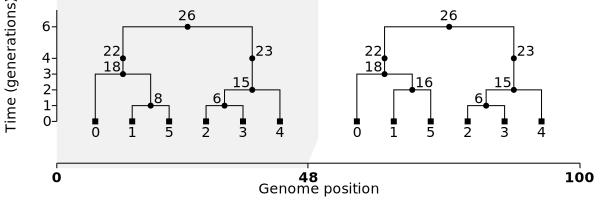

In [95]:
final_ts = msprime.sim_ancestry(
    initial_state=ped_ts, model="dtwf", population_size=10, random_seed=42)
SVG(final_ts.draw_svg(y_axis=True, size=(600,200)))

We can see that the nodes 22 and 23 representing the founder genomes
from the input pedigree are used as the starting point for the DTWF simulation,
which then finishes at generation 6 when the MRCA (node 26) is found.

(sec_ancestry_models_fixed_pedigree_missing_data)=

#### Missing pedigree data

The previous example is very straightforward because the pedigree is
complete and we can trace all individuals back to the same
generation in the pedigree. The pedigrees we have in practice
are usually not like this, and there is a great deal of missing data.
The consequence of this for the {class}`.FixedPedigree` simulations
is that genetic material will often be at a "dead end" at many
levels of the pedigree during a simulation.

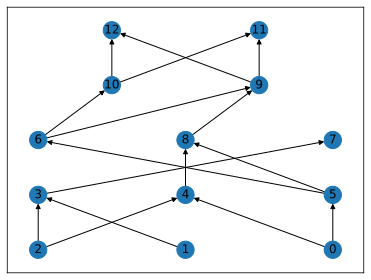

In [96]:
ped_txt = """\
# id parent0 parent1 time is_sample
0   5   4   0.0 1
1   3   3   0.0 1
2   3   4   0.0 1
3   7   7   1.0 0
4   8   8   1.0 0
5   8   6   1.0 0
6   9   10  2.0 0
7   .   .   2.0 0
8   9   9   2.0 0
9   11  12  3.0 0
10  11  12  3.0 0
11  .   .   4.0 0
12  .   .   4.0 0
"""
pedigree = msprime.parse_pedigree(io.StringIO(ped_txt), sequence_length=100)

draw_pedigree(pedigree.tree_sequence())

This pedigree has a "dead end" for individual 7, which is
reflected in the trees that we output from the {class}`.FixedPedigree` simulation:

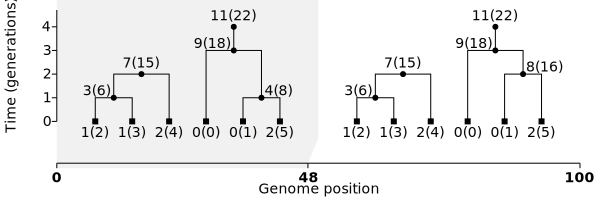

In [97]:
ped_ts = msprime.sim_ancestry(
    initial_state=pedigree, model="fixed_pedigree", random_seed=41,
    recombination_rate=0.001)
node_labels = {node.id: f"{node.individual}({node.id})" for node in ped_ts.nodes()}
SVG(ped_ts.draw_svg(y_axis=True,  node_labels=node_labels, size=(600,200)))

When we provide this tree sequence as the
{ref}`initial state<sec_ancestry_initial_state>` of another simulation, we
then effectively start the simulation at the earlier time point corresponding to
individual 7. Ancestral material in older parts of the pedigree is then
brought into the simulation in the same manner as
{ref}`ancient samples<sec_ancestry_samples_sampling_time>` as we proceed backwards
in time.

:::{warning}
It is important to note that although ancestral material for pedigree
founders is introduced into the recapitation simulation at the correct time,
no account is taken of the number of lineages present in the pedigree
when calculating population sizes. Thus, the pedigree must be seen as
entirely **external** to the population model simulated during recapitation.
:::

(sec_ancestry_models_fixed_pedigree_demography)=

#### Pedigrees and demography

For complex simulations in which our pedigree individuals (and
founders, in particular) are drawn from different populations,
we will want our follow-up recapitation simulations to use
a {ref}`demographic model<sec_demography>`. In order to do this,
we must define the demographic model *before* creating
the input pedigree. For example, consider the following
simple demography:

In [98]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=10)
demography.add_population(name="B", initial_size=20)
demography.add_population(name="C", initial_size=100)
demography.add_population_split(time=10, derived=["A", "B"], ancestral="C");

We define a pedigree in which the individuals belong
to the two "leaf" populations, A and B:

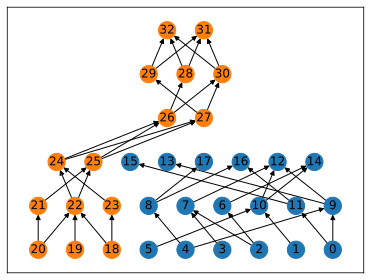

In [99]:
ped_txt = """\
# id    parent0 parent1 time    is_sample   population
0   9   11  0.0 1   A
1   10  10  0.0 1   A
2   6   7   0.0 1   A
3   7   7   0.0 1   A
4   8   9   0.0 1   A
5   10  10  0.0 1   A
6   14  14  1.0 0   A
7   12  12  1.0 0   A
8   16  17  1.0 0   A
9   12  13  1.0 0   A
10  14  12  1.0 0   A
11  15  16  1.0 0   A
12  .   .   2.0 0   A
13  .   .   2.0 0   A
14  .   .   2.0 0   A
15  .   .   2.0 0   A
16  .   .   2.0 0   A
17  .   .   2.0 0   A
18  23  22  0.0 1   B
19  22  22  0.0 1   B
20  21  22  0.0 1   B
21  25  25  1.0 0   B
22  24  25  1.0 0   B
23  24  24  1.0 0   B
24  27  26  2.0 0   B
25  27  26  2.0 0   B
26  30  28  3.0 0   B
27  30  29  3.0 0   B
28  31  32  4.0 0   B
29  31  32  4.0 0   B
30  32  31  4.0 0   B
31  .   .   5.0 0   B
32  .   .   5.0 0   B
"""
pedigree = msprime.parse_pedigree(
    io.StringIO(ped_txt), demography=demography, sequence_length=100)

draw_pedigree(pedigree.tree_sequence())

We can see that the pedigree is split into two sub-pedigrees for the
two populations, and the founders for the two populations exist
at different times (2 and 5 generations ago for A and B, respectively).
Running the {class}`.FixedPedigree` simulation, we can see that the
trees reflect this structure:

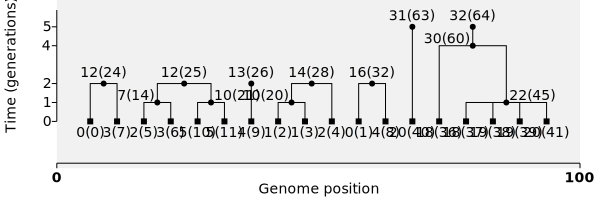

In [100]:
ped_ts = msprime.sim_ancestry(
    initial_state=pedigree, model="fixed_pedigree", random_seed=41)
node_labels = {node.id: f"{node.individual}({node.id})" for node in ped_ts.nodes()}
SVG(ped_ts.draw_svg(y_axis=True,  node_labels=node_labels, size=(600,200)))

When we complete this simulation we must use a {class}`.Demography` object
that matches the populations defined in the original pedigree tables. The
simplest way to do this is define the demography first, and use the same
object throughout as we have done here:

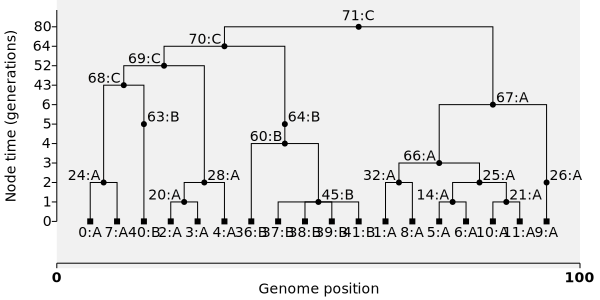

In [101]:
full_ts = msprime.sim_ancestry(
    initial_state=ped_ts, demography=demography, random_seed=42, model="dtwf")
node_labels = {
    node.id: f"{node.id}:{full_ts.population(node.population).metadata['name']}"
    for node in full_ts.nodes()}
SVG(full_ts.draw_svg(
    y_axis=True,  node_labels=node_labels, size=(600,300), time_scale="rank"))

Here we have changed the node labelling in the trees to show the name of the
population of each node. We can see that all of the early nodes are in the
populations defined from the pedigree. When the recapitation simulation begins,
all nodes are assigned into the relevant populations and the simulation proceeds
from there under the defined demography. In this demographic model, populations
A and B split from C 10 generations ago, and so the remaining lineages in populations
A and B evolve independently until this time. We can see that older coalescences
all happen within population C, as stipulated by the demographic model.

:::{warning}
The same caveats that we noted
{ref}`above<sec_ancestry_models_fixed_pedigree_missing_data>` about missing
data in the pedigree apply: although the remaining ancestral lineages
will join the simulation at the correct times and in the
specified population, *no account* is taken
of the number of extant lineages from the pedigree when computing
population sizes.
:::

(sec_ancestry_missing_data)=

## Missing data

:::{todo}
Give an example of doing a simulation with unknown rates on the flanks
and show that the resulting tree sequence has missing data in these
regions.
:::

(sec_ancestry_errors)=

## Common errors

(sec_ancestry_errors_infinite_waiting_time)=

### Infinite waiting time

```{eval-rst}
.. todo:: explain this, why it happens and give examples of when
   we don't detect it. Mention the possible_lineage_locations method.
```

In [102]:
demography = msprime.Demography()
demography.add_population(name="A", initial_size=1)
demography.add_population(name="B", initial_size=1)
msprime.sim_ancestry(samples={"A": 1, "B": 1}, demography=demography)

LibraryError: Infinite waiting time until next simulation event.